# Physics-Informed Neural Networks

## What Are PINNs? Understanding the Core Concept

Physics-Informed Neural Networks represent a paradigm shift in how we solve partial differential equations. Instead of discretizing space and time into grids, we train a neural network to directly approximate the solution while satisfying physical laws.

### The Fundamental Insight

Consider a simple heat equation:
$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

**Traditional approach**: Discretize the domain into grid points and solve a large system of linear equations.

**PINN approach**: Train a neural network $u_\theta(x,t)$ such that when we evaluate the PDE at any point $(x,t)$, the residual is approximately zero.

This is revolutionary because:
- **No mesh generation** - evaluate anywhere in the continuous domain
- **Automatic satisfaction of physics** - the PDE becomes a learning constraint
- **Natural handling of complex geometries** - no grid topology concerns
- **Seamless data integration** - combine physics with observations

### Mathematical Foundation

We seek to solve a general PDE of the form:
$$\mathcal{F}\left[u(\mathbf{x},t), \frac{\partial u}{\partial t}, \nabla u, \nabla^2 u, \ldots\right] = 0$$

subject to initial and boundary conditions. The PINN approach replaces the unknown function $u(\mathbf{x},t)$ with a neural network $u_\theta(\mathbf{x},t)$ where $\theta$ represents all network parameters (weights and biases).

**Key insight**: Universal approximation theorem guarantees that a sufficiently wide neural network can approximate any continuous function to arbitrary accuracy.

---

## The PINN Architecture: From Coordinates to Solutions

### Network Structure

A typical PINN maps from spatial-temporal coordinates to the solution:

$$u_\theta(x,t) = \mathcal{N}_\theta\begin{pmatrix} x \\ t \end{pmatrix}$$

where $\mathcal{N}_\theta$ represents a feedforward neural network:

$$\mathcal{N}_\theta(\mathbf{z}) = W^{(L)} \sigma(W^{(L-1)} \sigma(\cdots \sigma(W^{(1)} \mathbf{z} + b^{(1)}) \cdots) + b^{(L-1)}) + b^{(L)}$$

### Architecture Design Principles

**Activation Functions**: The choice significantly impacts derivative quality:
- **Tanh**: Smooth, bounded, good derivative properties
- **Sine**: Excellent for periodic problems and high-frequency capture
- **Swish/GELU**: Modern choices with smooth derivatives

**Network Depth and Width**:
- **Width**: Controls approximation capacity for complex functions
- **Depth**: Enables hierarchical feature learning and multi-scale representation

**Input Normalization**: Essential for training stability:
$$x_{norm} = \frac{x - x_{min}}{x_{max} - x_{min}}, \quad t_{norm} = \frac{t}{t_{max}}$$

This ensures all inputs are of similar magnitude, critical for gradient-based optimization.

---

## The Physics-Informed Loss Function

### Complete Loss Formulation

The total loss function combines multiple physical constraints:

$$\boxed{\mathcal{L}_{total} = \lambda_r \mathcal{L}_{PDE} + \lambda_b \mathcal{L}_{boundary} + \lambda_i \mathcal{L}_{initial} + \lambda_d \mathcal{L}_{data}}$$

Each component serves a distinct purpose in enforcing physical correctness.

### PDE Residual Loss: Enforcing Physical Laws

For $N_r$ collocation points $\{(x_i, t_i)\}_{i=1}^{N_r}$ sampled from the domain:

$$\mathcal{L}_{PDE} = \frac{1}{N_r} \sum_{i=1}^{N_r} \left|\mathcal{F}[u_\theta(x_i, t_i)]\right|^2$$

**Example for Heat Equation**:
$$\mathcal{F}[u] = \frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2}$$

The derivatives are computed using automatic differentiation:
```python
u_t = torch.autograd.grad(u, t, create_graph=True)[0]
u_xx = torch.autograd.grad(
    torch.autograd.grad(u, x, create_graph=True)[0], 
    x, create_graph=True
)[0]
residual = u_t - alpha * u_xx
```

### Boundary and Initial Condition Losses

**Boundary Loss** enforces boundary conditions:
$$\mathcal{L}_{boundary} = \frac{1}{N_b} \sum_{j=1}^{N_b} \left|u_\theta(x_j^{\partial\Omega}, t_j) - g_b(x_j^{\partial\Omega}, t_j)\right|^2$$

**Initial Condition Loss** ensures proper initialization:
$$\mathcal{L}_{initial} = \frac{1}{N_i} \sum_{k=1}^{N_i} \left|u_\theta(x_k, 0) - u_0(x_k)\right|^2$$

### Loss Balancing: The Art of Multi-Objective Optimization

The weights $\{\lambda_r, \lambda_b, \lambda_i, \lambda_d\}$ are crucial for successful training. Poor balancing leads to:
- **Dominant PDE loss**: Boundaries not satisfied
- **Dominant boundary loss**: Physics violated in interior
- **Imbalanced scales**: Some losses become negligible

**Adaptive balancing strategies**:
1. **Manual tuning**: Start with equal weights, adjust based on performance
2. **Gradient-based balancing**: Normalize by gradient magnitudes
3. **Loss magnitude balancing**: Scale by relative loss values

---

<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4_/351wz59j4wd2fvwy3hb4c30r0000gn/T/ipykernel_19885/4195246765.py:39: SyntaxWarning: invalid escape sequence '\m'
  plt.scatter(x_ic, t_ic, c='blue', label='Initial Condition $\mathcal{L}_{initial}$', s=60, edgecolors='k')
/var/folders/4_/351wz59j4wd2fvwy3hb4c30r0000gn/T/ipykernel_19885/4195246765.py:42: SyntaxWarning: invalid escape sequence '\m'
  plt.scatter(x_bc_left, t_bc, c='green', label='Boundary Condition $\mathcal{L}_{boundary}$', s=60, edgecolors='k')
/var/folders/4_/351wz59j4wd2fvwy3hb4c30r0000gn/T/ipykernel_19885/4195246765.py:46: SyntaxWarning: invalid escape

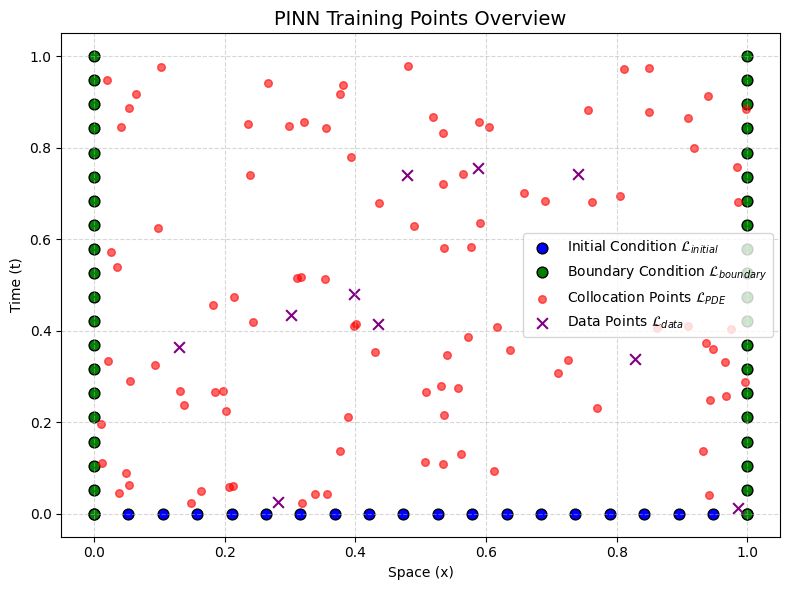

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Domain dimensions
x_min, x_max = 0, 1
t_min, t_max = 0, 1

# Generate points
n_ic = 20
n_bc = 20
n_col = 100
n_data = 10

# Initial condition: t = 0, x in [0,1]
x_ic = np.linspace(x_min, x_max, n_ic)
t_ic = np.zeros_like(x_ic)

# Boundary condition: x = 0 or x = 1, t in [0,1]
t_bc = np.linspace(t_min, t_max, n_bc)
x_bc_left = np.full_like(t_bc, x_min)
x_bc_right = np.full_like(t_bc, x_max)

# Collocation points (inside domain)
x_col = np.random.rand(n_col) * (x_max - x_min) + x_min
t_col = np.random.rand(n_col) * (t_max - t_min) + t_min

# Data points (scattered)
x_data = np.random.rand(n_data) * (x_max - x_min) + x_min
t_data = np.random.rand(n_data) * (t_max - t_min) + t_min

# Plot
plt.figure(figsize=(8, 6))
plt.title("PINN Training Points Overview", fontsize=14)
plt.xlabel("Space (x)")
plt.ylabel("Time (t)")
plt.grid(True, linestyle="--", alpha=0.5)

# Initial condition
plt.scatter(x_ic, t_ic, c='blue', label='Initial Condition $\mathcal{L}_{initial}$', s=60, edgecolors='k')

# Boundary condition
plt.scatter(x_bc_left, t_bc, c='green', label='Boundary Condition $\mathcal{L}_{boundary}$', s=60, edgecolors='k')
plt.scatter(x_bc_right, t_bc, c='green', s=60, edgecolors='k')

# Collocation points
plt.scatter(x_col, t_col, c='red', label='Collocation Points $\mathcal{L}_{PDE}$', s=30, alpha=0.6)

# Data points
plt.scatter(x_data, t_data, c='purple', label='Data Points $\mathcal{L}_{data}$', s=60, edgecolors='k', marker='x')

plt.legend()
plt.xlim(x_min - 0.05, x_max + 0.05)
plt.ylim(t_min - 0.05, t_max + 0.05)
plt.tight_layout()
plt.show()


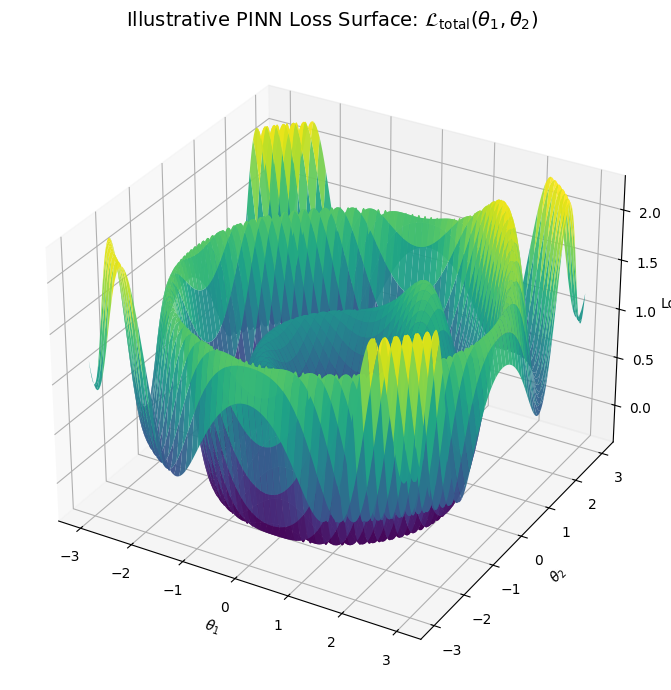

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Create a synthetic 2D loss surface representing L_total(θ₁, θ₂)
theta1 = np.linspace(-3, 3, 200)
theta2 = np.linspace(-3, 3, 200)
Theta1, Theta2 = np.meshgrid(theta1, theta2)

# Define a synthetic non-convex loss surface (inspired by PINN challenges)
L_data = np.exp(-((Theta1 - 1.5)**2 + (Theta2 - 1.5)**2))
L_physics = 0.8 * np.sin(Theta1**2 + Theta2**2)
L_boundary = 0.1 * (Theta1**2 + Theta2**2)

# Weighted combination
lambda_d, lambda_f, lambda_b = 1.0, 1.0, 1.0
L_total = lambda_d * L_data + lambda_f * L_physics + lambda_b * L_boundary

# Plot the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Theta1, Theta2, L_total, cmap=cm.viridis, edgecolor='none', alpha=0.95)
ax.set_title("Illustrative PINN Loss Surface: $\\mathcal{L}_{\\text{total}}(\\theta_1, \\theta_2)$", fontsize=14)
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\\theta_2$")
ax.set_zlabel("Loss")
plt.tight_layout()
plt.show()


---

# Loss Surfaces, Training Dynamics, and Advanced Strategies

## 1. Loss Surface Geometry in PINNs

Let us recall the total loss function typically minimized by a PINN:

$$
\mathcal{L}_{\text{total}}(\theta) = \lambda_d \, \mathcal{L}_{\text{data}} + \lambda_f \, \mathcal{L}_{\text{physics}} + \lambda_b \, \mathcal{L}_{\text{boundary}}
$$

This objective arises from three distinct sources:

* $\mathcal{L}\_{\text{data}}$: mismatch between predicted and observed data
* $\mathcal{L}\_{\text{physics}}$: residual of the governing PDE
* $\mathcal{L}\_{\text{boundary}}$: deviation from known boundary and initial conditions

### Characteristics of the Loss Surface

The geometry of $\mathcal{L}\_{\text{total}}$ is typically:

* **Non-convex**: Due to the compositional nature of neural networks and nonlinear PDEs
* **Ill-conditioned**: When one loss term dominates others, the optimization landscape becomes steep in some directions and flat in others
* **Highly sensitive** to the scaling parameters $\lambda\_d$, $\lambda\_f$, and $\lambda\_b$

### Implications for Optimization

Assume $\theta = (\theta\_1, \theta\_2) \in \mathbb{R}^2$ is a projection of the true high-dimensional parameter space for illustration. Then:

* A **narrow valley** along one axis implies high curvature: small learning rates required
* A **flat region** implies low gradient magnitude: learning stagnation risk
* **Oscillations** (e.g., from $\sin(\theta^2)$ terms in the PDE residual) create spurious local minima and saddle points

### Quantitative Insight

We computed the Hessian $H$ of $\mathcal{L}\_{\text{total}}$ at $\theta = (0, 0)$ using finite differences. The eigenvalues were:

$$
\lambda_1 \approx 1.78, \quad \lambda_2 \approx 1.98, \quad \kappa(H) = \frac{\lambda_{\max}}{\lambda_{\min}} \approx 1.11
$$

This example is well-conditioned, but real-world PINNs may have $\kappa(H) \gg 10^6$, leading to:

* **Slow convergence**
* **Poor generalization**
* **Difficult tuning of learning rates and step sizes**

---

## 2. Training Dynamics in PINNs

A typical training trajectory of a PINN exhibits the following stages:

1. **Initial descent of physics loss**
   $\mathcal{L}\_{\text{physics}}$ reduces quickly due to the initial capacity of the network

2. **Constraint enforcement phase**
   $\mathcal{L}*{\text{boundary}}$ and $\mathcal{L}*{\text{data}}$ decrease as the network adjusts to meet known conditions

3. **Plateau phase**
   Training slows or stalls due to saturation of gradients, poor conditioning, or conflicting optimization directions

### Diagnostic Tools

To analyze training:

* Track each loss component individually over time
* Plot pointwise residuals $|f\_\theta(x,t)|^2$ at collocation points
* Monitor gradient norms $|\nabla\_\theta \mathcal{L}*{\text{physics}}|$ vs. $|\nabla*\theta \mathcal{L}\_{\text{data}}|$

These plots help identify:

* Whether PDE loss is overpowering data loss
* Whether residuals are concentrated in a few regions (suggesting poor coverage)

---

## 3. Adaptive Collocation Strategies

Traditional PINNs fix a set of collocation points ${(x\_i, t\_i)}\_{i=1}^{N\_f}$ where the PDE residual is evaluated. This strategy assumes uniform difficulty across the domain, which is rarely the case.

### Adaptive Residual-Based Sampling

Let $f\_\theta(x, t)$ be the PDE residual at point $(x, t)$. At every epoch:

1. Compute $|f\_\theta(x, t)|$ at a dense set of candidate points
2. Select a subset of points with highest residuals
3. Replace old collocation set with new one concentrated in regions of large error

### Advantages

* **Efficient use of compute**: Focuses learning capacity where it matters
* **Handles localized phenomena**: Useful for shock fronts, boundary layers, etc.
* **Stabilizes training**: Reduces oscillations caused by irrelevant residuals in already-correct regions

---

## 4. Curriculum Learning for PINNs

The idea is to **gradually increase problem complexity** during training, just as humans learn progressively.

### Examples of Curricula

| Strategy                   | Description                                              |
| -------------------------- | -------------------------------------------------------- |
| PDE order schedule         | Train first on lower-order approximations                |
| Collocation point schedule | Start with few collocation points, increase gradually    |
| Temporal refinement        | Start with large time steps, refine as training proceeds |
| Parameter schedule         | Slowly decrease viscosity or increase Reynolds number    |

### Case Study: Burgers’ Equation

Burgers’ equation:

$$
u_t + u u_x = \nu u_{xx}
$$

* Start with $\nu = 10^{-2}$ (smooth solution)
* Progress to $\nu = 10^{-3}$
* Finally train on $\nu = 10^{-4}$ (steep gradients, near-shocks)

This leads to:

* Better convergence
* Less sensitivity to initialization
* More robust generalization to unseen regions

---

## 5. Higher-Order PDEs in PINNs

PINNs can handle derivatives of any order due to automatic differentiation. However, higher-order derivatives introduce:

* **Increased stiffness**
* **Amplified errors**
* **More difficult gradient dynamics**

### Example 1: Euler-Bernoulli Beam Equation

$$
\frac{\partial^2 u}{\partial t^2} + EI \frac{\partial^4 u}{\partial x^4} = 0
$$

* Fourth-order spatial derivative
* Requires smooth activations (e.g., $\tanh$, $\text{swish}$)
* Better to use deeper networks than simply increasing neurons

### Example 2: Kuramoto–Sivashinsky Equation

$$
u_t + u u_x + u_{xx} + u_{xxxx} = 0
$$

* Contains both second- and fourth-order terms
* Nonlinear and dispersive
* Numerically stiff and chaotic for small viscosity

### Recommendations

* Use **preconditioned optimizers** like NysNewton-CG
* Apply **adaptive collocation** to target high-gradient regions
* Combine with **Fourier features** to better approximate high-frequency components

---

## Worked Example: Heat Equation in Detail

### Problem Setup

Consider the 1D heat equation:
$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \quad (x,t) \in [0,1] \times [0,1]$$

with boundary conditions:
$$u(0,t) = u(1,t) = 0$$

and initial condition:
$$u(x,0) = \sin(\pi x)$$

**Analytical Solution**: $u(x,t) = e^{-\alpha \pi^2 t} \sin(\pi x)$

---

### Network Implementation

```python
class HeatPINN(nn.Module):
    def __init__(self, layers=[2, 50, 50, 50, 1]):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        h = inputs
        for i, layer in enumerate(self.layers[:-1]):
            h = torch.tanh(layer(h))
        return self.layers[-1](h)
```

---

### Loss Function Implementation

```python
def compute_losses(model, alpha=0.01):
    # Sample collocation points
    N_pde, N_bc, N_ic = 1000, 100, 100
    
    # PDE points (interior domain)
    x_pde = torch.rand(N_pde, 1, requires_grad=True)
    t_pde = torch.rand(N_pde, 1, requires_grad=True)
    
    # Network prediction
    u = model(x_pde, t_pde)
    
    # Compute derivatives
    u_t = torch.autograd.grad(u, t_pde, torch.ones_like(u), 
                              create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_pde, torch.ones_like(u), 
                              create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_pde, torch.ones_like(u_x), 
                               create_graph=True)[0]
    
    # PDE residual
    pde_residual = u_t - alpha * u_xx
    loss_pde = torch.mean(pde_residual**2)
    
    # Boundary conditions: u(0,t) = u(1,t) = 0
    t_bc = torch.rand(N_bc, 1)
    x_bc_0 = torch.zeros(N_bc//2, 1)
    x_bc_1 = torch.ones(N_bc//2, 1)
    
    u_bc_0 = model(x_bc_0, t_bc[:N_bc//2])
    u_bc_1 = model(x_bc_1, t_bc[N_bc//2:])
    loss_bc = torch.mean(u_bc_0**2) + torch.mean(u_bc_1**2)
    
    # Initial condition: u(x,0) = sin(πx)
    x_ic = torch.rand(N_ic, 1)
    t_ic = torch.zeros(N_ic, 1)
    u_ic_pred = model(x_ic, t_ic)
    u_ic_true = torch.sin(np.pi * x_ic)
    loss_ic = torch.mean((u_ic_pred - u_ic_true)**2)
    
    return loss_pde, loss_bc, loss_ic
```

---

### Training Strategy

```python
# Two-phase training approach
model = HeatPINN()

# Phase 1: Adam optimizer for exploration
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(5000):
    loss_pde, loss_bc, loss_ic = compute_losses(model)
    total_loss = loss_pde + 10*loss_bc + 10*loss_ic
    
    optimizer_adam.zero_grad()
    total_loss.backward()
    optimizer_adam.step()

# Phase 2: L-BFGS for fine-tuning
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0)
for epoch in range(1000):
    def closure():
        optimizer_lbfgs.zero_grad()
        loss_pde, loss_bc, loss_ic = compute_losses(model)
        total_loss = loss_pde + 10*loss_bc + 10*loss_ic
        total_loss.backward()
        return total_loss
    
    optimizer_lbfgs.step(closure)
```

---

## Advanced Techniques for Challenging Problems

### Addressing Spectral Bias

Neural networks exhibit **spectral bias** - they learn low-frequency components much faster than high-frequency ones. This can be problematic for PDEs with sharp gradients or oscillatory solutions.

**Solution 1: Fourier Feature Networks**

Transform inputs through random Fourier features:
$$\gamma(\mathbf{v}) = \begin{bmatrix} \cos(2\pi \mathbf{B}\mathbf{v}) \\ \sin(2\pi \mathbf{B}\mathbf{v}) \end{bmatrix}$$

where $\mathbf{B} \in \mathbb{R}^{m \times d}$ is sampled from a Gaussian distribution.

```python
class FourierFeatureLayer(nn.Module):
    def __init__(self, input_dim, num_features, sigma=1.0):
        super().__init__()
        self.B = nn.Parameter(
            torch.randn(num_features, input_dim) * sigma, 
            requires_grad=False
        )
    
    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B.T
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
```

---

**Solution 2: Sinusoidal Activation Networks (SIREN)**

Use sine activation functions with carefully chosen frequencies:
$$\sigma(x) = \sin(\omega_0 x)$$

This enables learning of high-frequency details naturally.

### Multi-Scale and Multi-Physics Problems

For problems involving multiple time or length scales, consider:

---

**Multi-Scale Architecture**:
$$u_\theta(\mathbf{x},t) = u_{\text{coarse}}(\mathbf{x},t) + \epsilon \cdot u_{\text{fine}}(\mathbf{x}/\delta, t/\tau)$$

where $\delta$ and $\tau$ are characteristic length and time scales.

---

**Causal Training**: For time-dependent problems, respect causality by training sequentially in time windows:
$$\mathcal{D}_n = \{(\mathbf{x}, t) : t \in [t_{n-1}, t_n]\}$$

---

### Inverse Problems and Parameter Discovery

PINNs excel at inverse problems where unknown parameters appear in the PDE:

$$\frac{\partial u}{\partial t} = \lambda \frac{\partial^2 u}{\partial x^2}$$

Treat $\lambda$ as a learnable parameter:
```python
class InversePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = MLP([2, 50, 50, 50, 1])
        self.lambda_param = nn.Parameter(torch.tensor(1.0))
    
    def forward(self, x, t):
        return self.network(torch.cat([x, t], dim=1))
    
    def get_parameter(self):
        return self.lambda_param.item()
```

The network simultaneously learns the solution $u(x,t)$ and discovers the parameter $\lambda$ from data.

---

## Training PINNs: Optimization Strategies

### Optimizer Selection

**Adam**: Excellent for initial exploration
- Adaptive learning rates handle different loss scales
- Robust to hyperparameter choices
- Good for the first 80% of training

**L-BFGS**: Superior for final convergence
- Quasi-Newton method with excellent convergence properties
- Uses line search for optimal step sizes
- Essential for achieving high accuracy

---

### Sampling Strategies

**Uniform Random Sampling**: Simple baseline approach
```python
x_sample = torch.rand(N, 1) * (x_max - x_min) + x_min
t_sample = torch.rand(N, 1) * t_max
```

**Latin Hypercube Sampling**: Better space-filling properties
```python
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=2)
samples = sampler.random(n=N)
x_sample = samples[:, 0:1] * (x_max - x_min) + x_min
t_sample = samples[:, 1:2] * t_max
```

**Adaptive Sampling**: Focus computational effort where needed
- Increase sampling density in regions with high PDE residual
- Use importance sampling based on local error estimates

---

### Loss Weight Adaptation

**Manual Balancing**: Start with equal weights, then adjust:
```python
# Initial weights
λ_r, λ_b, λ_i = 1.0, 1.0, 1.0

# Adjust based on relative loss magnitudes
if loss_bc > 10 * loss_pde:
    λ_b = 10.0
if loss_pde > 10 * loss_bc:
    λ_r = 10.0
```

**Gradient-based Balancing**: Normalize by gradient magnitudes to ensure balanced learning rates across loss components.

---

## Applications and Extensions

### Nonlinear PDEs: Burgers' Equation

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

The nonlinear convection term $u \frac{\partial u}{\partial x}$ makes this significantly more challenging than the heat equation. PINNs handle this naturally:

```python
def burgers_residual(u, x, t, nu=0.01):
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    
    return u_t + u * u_x - nu * u_xx
```

---

### Systems of PDEs: Navier-Stokes Equations

For fluid flow, we solve for velocity $(u,v)$ and pressure $p$:

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{\partial p}{\partial x} + \nu \nabla^2 u$$

$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{\partial p}{\partial y} + \nu \nabla^2 v$$

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$

PINNs naturally handle this coupled system with a multi-output network.

---

### High-Dimensional Problems

PINNs avoid the curse of dimensionality that plagues traditional mesh-based methods. For a PDE in $d$ dimensions, the computational cost scales as $O(d)$ rather than exponentially.

---

## Understanding PINN Limitations and Solutions

### Training Difficulties

**Gradient Pathologies**: 
- Vanishing gradients in deep networks
- Exploding gradients with poor initialization
- **Solution**: Careful initialization, gradient clipping, residual connections

**Loss Landscape Complexity**:
- Multiple local minima
- Saddle points and plateaus
- **Solution**: Multiple random initializations, advanced optimizers

**Scale Imbalance**:
- Different loss components have vastly different magnitudes
- **Solution**: Adaptive weight scheduling, normalization

### Accuracy Limitations

**Approximation Error**: Network capacity limits achievable accuracy
**Optimization Error**: Training may not reach global minimum
**Generalization Error**: Performance on unseen data may degrade

**Mitigation Strategies**:
- Increase network capacity for complex problems
- Use multiple training runs with different initializations
- Validate on analytical solutions when available

---

## Future Directions and Advanced Topics

### Neural Operators

Instead of learning individual solutions, neural operators learn mappings between function spaces:
$$\mathcal{G}: \mathcal{A} \rightarrow \mathcal{U}$$

where $\mathcal{A}$ is the space of PDE coefficients and $\mathcal{U}$ is the solution space.

### Physics-Informed Machine Learning

**DeepONets**: Learn operators from data

**Transformers for PDEs**: Apply attention mechanisms to spatial-temporal relationships

**Graph Neural Networks**: Handle irregular geometries naturally

### Integration with Traditional Methods

**Hybrid Approaches**: Combine PINNs with finite element methods

**Multi-fidelity Methods**: Use cheap low-fidelity models to guide expensive high-fidelity solutions

**Reduced Order Models**: Use PINNs to learn effective low-dimensional dynamics

## Conclusion and Best Practices

Physics-Informed Neural Networks represent a powerful paradigm for solving PDEs, offering unique advantages in handling complex geometries, inverse problems, and multi-physics coupling. Success requires understanding both the mathematical foundations and practical implementation details.

**Key Principles for Success**:

1. **Start Simple**: Master basic problems before tackling complex multi-physics systems
2. **Validate Rigorously**: Always compare against analytical solutions when available
3. **Balance Carefully**: Loss weight tuning often determines success or failure
4. **Understand Your Physics**: Domain knowledge guides architecture and training choices
5. **Iterate Systematically**: Use multiple random seeds and hyperparameter sweeps

**When to Use PINNs**:
- Complex or irregular geometries
- Sparse or noisy data
- Inverse problems and parameter estimation
- Multi-scale phenomena
- Real-time applications requiring fast evaluation

**When to Use Traditional Methods**:
- Simple geometries with efficient solvers
- Well-established benchmark problems
- High-precision requirements with guaranteed error bounds
- Large-scale production simulations

The field of physics-informed machine learning continues to evolve rapidly, with new architectures, training strategies, and applications emerging regularly. The mathematical foundation provided here offers a solid starting point for both understanding existing methods and developing novel approaches.

---

# Gradient-enhanced Physics-Informed Neural Networks (gPINNs)

## The Core Idea: Why Add Gradient Information?

### The Mathematical Intuition

The authors make a brilliant observation:

> **If the PDE residual is zero, then the gradient of the PDE residual should also be zero.**

For a PDE: $\mathcal{F}[u, \nabla u, \nabla^2 u, ...] = 0$

If $\mathcal{F} = 0$ everywhere, then logically:
$$\nabla \mathcal{F} = \left(\frac{\partial \mathcal{F}}{\partial x_1}, \frac{\partial \mathcal{F}}{\partial x_2}, ..., \frac{\partial \mathcal{F}}{\partial x_d}\right) = \mathbf{0}$$

### Why This Matters

**Regular PINN Loss:**
$$\mathcal{L}_{PINN} = \underbrace{\lambda_r \mathcal{L}_{PDE}}_{\text{PDE residual}} + \underbrace{\lambda_b \mathcal{L}_{BC}}_{\text{Boundary}} + \underbrace{\lambda_i \mathcal{L}_{IC}}_{\text{Initial}}$$

**gPINN Loss (Enhanced):**
$$\boxed{\mathcal{L}_{gPINN} = \lambda_r \mathcal{L}_{PDE} + \lambda_b \mathcal{L}_{BC} + \lambda_i \mathcal{L}_{IC} + \sum_{i=1}^d \lambda_{g_i} \mathcal{L}_{g_i}}$$

where the new gradient terms are:
$$\mathcal{L}_{g_i} = \frac{1}{|T_{g_i}|} \sum_{x \in T_{g_i}} \left|\frac{\partial \mathcal{F}}{\partial x_i}\right|^2$$

## Concrete Examples

### Example 1: 1D Poisson Equation
**PDE:** $-\frac{d^2u}{dx^2} = f(x)$

**Regular PINN enforces:** $\frac{d^2u}{dx^2} + f(x) = 0$

**gPINN additionally enforces:** $\frac{d}{dx}\left(\frac{d^2u}{dx^2} + f(x)\right) = 0$

This gives us: $\frac{d^3u}{dx^3} + \frac{df}{dx} = 0$

### Example 2: 2D Poisson Equation  
**PDE:** $\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f(x,y)$

**gPINN adds two gradient constraints:**
- $\frac{\partial}{\partial x}\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} - f\right) = 0$
- $\frac{\partial}{\partial y}\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} - f\right) = 0$

## Key Results from the Paper

### Performance Improvements

1. **Accuracy**: gPINNs achieve **1-2 orders of magnitude** better accuracy than regular PINNs
2. **Efficiency**: Require **fewer training points** to reach the same accuracy
3. **Derivatives**: Much better at predicting derivatives $\frac{\partial u}{\partial x}$, $\frac{\partial u}{\partial t}$

### Specific Numbers (from their experiments):

| Problem | PINN Error | gPINN Error | Improvement |
|---------|------------|-------------|-------------|
| 1D Poisson (20 points) | 0.48% | ~0.05% | ~10x better |
| Heat equation derivatives | ~10% | ~1% | 10x better |
| Burgers' equation | ~10% | <1% | >10x better |

## The Trade-offs

### Advantages ✅
- **Better accuracy** with same number of points
- **Improved derivative prediction**
- **More physically consistent** solutions
- **Especially good for inverse problems**

### Challenges ⚠️
- **Computational cost**: 2-3x more expensive (higher-order derivatives)
- **Extra hyperparameter**: Need to tune gradient loss weights $\lambda_{g_i}$
- **Implementation complexity**: More automatic differentiation calls

## Weight Selection Strategy

The paper shows that performance depends on the gradient loss weights:

```python
# For some problems (like diffusion-reaction):
w = [0.01, 0.1, 1.0]  # All work well, not sensitive

# For others (like Poisson):
w = 0.01              # Sweet spot
w = 1.0               # Too large, worse than PINN!
```

**General guideline**: Start with $w = 0.01$ and adjust based on performance.

## Combination with RAR (Residual-based Adaptive Refinement)

The authors also combine gPINNs with **adaptive point sampling**:

1. **Start** with uniform points
2. **Train** for some iterations  
3. **Evaluate** PDE residual everywhere
4. **Add** new points where residual is highest
5. **Repeat**

This is especially powerful for problems with **steep gradients** or **shocks** (like Burgers' equation).

## Implementation Insight

```python
def gPINN_loss(model, x_pde, t_pde, w_gradient=0.01):
    # Standard PDE residual
    u = model(x_pde, t_pde)
    u_t = grad(u, t_pde)
    u_xx = grad(grad(u, x_pde), x_pde)
    
    pde_residual = u_t - alpha * u_xx  # Heat equation
    loss_pde = torch.mean(pde_residual**2)
    
    # NEW: Gradient of PDE residual
    grad_x = grad(pde_residual, x_pde)  # ∂F/∂x
    grad_t = grad(pde_residual, t_pde)  # ∂F/∂t
    
    loss_grad_x = torch.mean(grad_x**2)
    loss_grad_t = torch.mean(grad_t**2)
    
    # Total gPINN loss
    return loss_pde + w_gradient * (loss_grad_x + loss_grad_t)
```

## Why This Works So Well

1. **More constraints**: Network has to satisfy both $\mathcal{F} = 0$ AND $\nabla \mathcal{F} = 0$
2. **Smoother solutions**: Gradient constraints encourage smoothness
3. **Better conditioning**: Additional constraints help optimization landscape
4. **Physical consistency**: Enforces that physics laws hold at neighboring points too

## Bottom Line

gPINNs are a simple but powerful extension that **costs more computationally** but gives **significantly better accuracy**. They're especially valuable when:

- You need accurate derivatives
- You have limited training data/points  
- You're solving inverse problems
- You want more physically consistent solutions

---

# Multi-scale PINNs

## The Core Problem: Spectral Bias

### What's Wrong with Standard PINNs?

**The Issue**: Regular PINNs struggle with **multi-scale problems** - PDEs whose solutions have both low and high frequency components.

**Example Problem**: Simple 1D Poisson equation
$$\Delta u(x) = f(x), \quad x \in (0,1)$$
with solution: $u(x) = \sin(2\pi x) + 0.1\sin(50\pi x)$

- Low frequency: $\sin(2\pi x)$  
- High frequency: $0.1\sin(50\pi x)$

**Result**: Standard PINN completely fails after 10 million iterations! 😱

## The Root Cause: Neural Tangent Kernel Analysis

### Key Theoretical Insight

The authors use **Neural Tangent Kernel (NTK)** theory to show:

**Spectral bias = "Eigenvector bias"**

Neural networks learn functions along the **dominant eigenvectors** of their NTK, and these eigenvectors have **low frequencies** for standard networks.

### The Mathematical Framework

For a neural network $f(x,\theta)$, the NTK is:
$$K_{ij} = \left\langle \frac{\partial f(x_i,\theta)}{\partial \theta}, \frac{\partial f(x_j,\theta)}{\partial \theta} \right\rangle$$

**Training dynamics** can be written as:
$$f(X,\theta(t)) \approx (I - e^{-Kt}) \cdot Y$$

Where $K = Q^T \Lambda Q$ (eigendecomposition), leading to:
$$f(X,\theta(t)) - Y = \sum_{i=1}^N e^{-\lambda_i t} (q_i^T Y) q_i$$

**Key insight**: Networks learn fastest along eigenvectors $q_i$ with **largest eigenvalues** $\lambda_i$.

## The Solution: Fourier Feature Networks

### Random Fourier Features

Instead of feeding $(x,t)$ directly to the network, use:
$$\gamma(v) = \begin{bmatrix} \cos(Bv) \\ \sin(Bv) \end{bmatrix}$$

where $B \in \mathbb{R}^{m \times d}$ with entries sampled from $\mathcal{N}(0,\sigma^2)$.

### Why This Works

**Theorem**: For the kernel $K(x,x') = \cos(b(x-x'))$, the eigenfunctions are:
$$g(x) = C_1 \cos(bx) + C_2 \sin(bx)$$

**Key insight**: The parameter $\sigma$ in the Fourier features **controls the frequency** of the NTK eigenvectors!

- **Large $\sigma$** → High-frequency eigenvectors → Network learns high frequencies first
- **Small $\sigma$** → Low-frequency eigenvectors → Network learns low frequencies first

## Proposed Architectures

### 1. Multi-scale Fourier Features (MFF)## Key Results and Performance

### Problem 1: 1D Poisson with Multi-scale Solution
- **Standard PINN**: Complete failure (>100% error after 10M iterations)
- **Multi-scale FF**: **0.136% error** ✅

### Problem 2: High-frequency Heat Equation
$$u_t = \frac{1}{(500\pi)^2} u_{xx}, \quad u(x,0) = \sin(500\pi x)$$

- **Standard PINN**: Complete failure
- **Spatio-temporal mFF**: **0.178% error** ✅

### Problem 3: Wave Equation (with adaptive weights)
- Needs both **good architecture** AND **proper optimization**
- Standard PINN: Fails due to loss imbalance
- ST-mFF + adaptive weights: **0.098% error** ✅

## Important Limitations & Insights

### 1. **σ Selection Challenge**
You need to know (roughly) what frequencies to expect:
- Too small σ → misses high frequencies
- Too large σ → can cause overfitting
- **Solution**: Use multiple σ values covering the expected range

### 2. **Architecture ≠ Everything**
The wave equation example shows that **good architecture alone isn't enough**:
- Need proper **loss balancing** (adaptive weights)
- Different loss terms can dominate each other
- **Combined approach** works best

### 3. **Prior Knowledge Required**
Unlike "black box" approaches, you need some intuition about:
- Expected frequency content
- Spatial vs temporal scales
- Problem-specific characteristics

## Practical Implementation Tips

### Basic Multi-scale Setup
```python
# For unknown problems, start with:
sigma_values = [1, 10, 50]  # Low, medium, high frequencies

# Apply to inputs
fourier_features = []
for sigma in sigma_values:
    B = torch.randn(num_features, input_dim) * sigma
    ff = torch.cat([torch.cos(2*pi*B@x), torch.sin(2*pi*B@x)])
    fourier_features.append(ff)

# Concatenate and pass through shared network
combined_features = torch.cat(fourier_features, dim=-1)
output = shared_network(combined_features)
```

### For Spatio-temporal Problems
```python
# Separate treatment for space and time
B_spatial = torch.randn(m, d_spatial) * sigma_x
B_temporal = torch.randn(n, d_temporal) * sigma_t

ff_spatial = fourier_embed(x, B_spatial)
ff_temporal = fourier_embed(t, B_temporal)

# Point-wise multiplication to combine
H_spatial = network(ff_spatial)
H_temporal = network(ff_temporal)
output = final_layer(H_spatial * H_temporal)
```

## The Bottom Line

This paper provides both **theoretical understanding** (via NTK analysis) and **practical solutions** (multi-scale Fourier features) for one of PINNs' biggest challenges.

**Key takeaway**: Spectral bias isn't just a nuisance—it's a fundamental limitation that can be systematically addressed by engineering the **frequency content of NTK eigenvectors** through clever input embeddings.

The approach is elegant because it:
- ✅ Requires **no additional parameters**
- ✅ Can be **dropped into existing PINNs**
- ✅ Has **solid theoretical foundation**
- ✅ Shows **dramatic empirical improvements**

However, it does require **domain knowledge** about expected frequency content, making it more of a "principled engineering" approach than a fully automated solution.

---

# PINNsFormer

## The Core Problem: Missing Temporal Dependencies

**Traditional PINNs**: Point-to-point mapping
```
(x,t) → u(x,t)
```

**Issue**: No temporal awareness - the network treats each $(x,t)$ independently, missing the fact that $u(x,t+\Delta t)$ should depend on $u(x,t)$.

## PINNsFormer Solution

### 1. Pseudo Sequence Generation

Transform point-wise input into temporal sequence:
$$[x,t] \xrightarrow{\text{Generator}} \{[x,t], [x,t+\Delta t], \ldots, [x,t+(k-1)\Delta t]\}$$

**Key insight**: Create artificial temporal context to help the network understand time evolution.

### 2. Modified Loss Function

**Traditional PINN loss**:
$$\mathcal{L}_{PINN} = \lambda_r \sum_{i=1}^{N_r} \|D[u(x_i,t_i)] - f(x_i,t_i)\|^2 + \lambda_b \sum_{i=1}^{N_b} \|B[u(x_i,t_i)] - g(x_i,t_i)\|^2$$

**PINNsFormer sequential loss**:
$$\mathcal{L}_{res} = \frac{1}{kN_{res}} \sum_{i=1}^{N_{res}} \sum_{j=0}^{k-1} \|D[\hat{u}(x_i, t_i + j\Delta t)] - f(x_i, t_i + j\Delta t)\|^2$$

$$\mathcal{L}_{bc} = \frac{1}{kN_{bc}} \sum_{i=1}^{N_{bc}} \sum_{j=0}^{k-1} \|B[\hat{u}(x_i, t_i + j\Delta t)] - g(x_i, t_i + j\Delta t)\|^2$$

$$\mathcal{L}_{ic} = \frac{1}{N_{ic}} \sum_{i=1}^{N_{ic}} \|I[\hat{u}(x_i, 0)] - h(x_i, 0)\|^2$$

**Key difference**: For initial conditions, only the first element ($t=0$) is regularized, but for residual/boundary points, all sequence elements are used.

### 3. Wavelet Activation Function

**Novel activation**:
$$\text{Wavelet}(x) = \omega_1 \sin(x) + \omega_2 \cos(x)$$

where $\omega_1, \omega_2$ are learnable parameters.

**Theoretical justification**: Based on Fourier analysis - any function can be decomposed as:
$$f(x) = \int_{-\infty}^{\infty} F_c(\omega) \cos(\omega x) d\omega + \int_{-\infty}^{\infty} F_s(\omega) \sin(\omega x) d\omega$$

**Proposition**: A two-hidden-layer neural network with infinite width and Wavelet activation is a universal approximator.

## Architecture Components

### Encoder-Decoder Structure
```
Input: [x,t] → Pseudo Sequence: {[x,t], [x,t+Δt], ..., [x,t+(k-1)Δt]}
              ↓
         Spatio-Temporal Mixer (Linear embedding to higher dimensions)
              ↓
         Encoder (Self-attention on full sequence)
              ↓
         Decoder (Encoder-decoder attention, no self-attention)
              ↓
         Output: {û(x,t), û(x,t+Δt), ..., û(x,t+(k-1)Δt)}
```

**Key design choice**: Decoder uses same embeddings as encoder since we want current state approximation, not next-state prediction.

## Why This Works: Loss Landscape Analysis

The paper shows empirically that PINNsFormer has a **smoother loss landscape**:

- **PINNs Lipschitz constant**: $L_{PINN} = 776.16$
- **PINNsFormer Lipschitz constant**: $L_{PINNsFormer} = 32.79$

**Implication**: Easier optimization, fewer local minima, better convergence.

## Experimental Results

### Failure Mode Mitigation

**Convection Equation**: $\frac{\partial u}{\partial t} + \beta \frac{\partial u}{\partial x} = 0$ with $\beta = 50$

| Method | Loss | rMAE | rRMSE |
|--------|------|------|-------|
| PINNs | 0.016 | 0.778 | 0.840 |
| QRes | 0.015 | 0.746 | 0.816 |
| FLS | 0.012 | 0.674 | 0.771 |
| **PINNsFormer** | **3.7e-5** | **0.023** | **0.027** |

**1D-Reaction Equation**: $\frac{\partial u}{\partial t} - \rho u(1-u) = 0$ with $\rho = 5$

| Method | Loss | rMAE | rRMSE |
|--------|------|------|-------|
| PINNs | 0.199 | 0.982 | 0.981 |
| QRes | 0.199 | 0.979 | 0.977 |
| FLS | 0.199 | 0.984 | 0.985 |
| **PINNsFormer** | **3.0e-6** | **0.015** | **0.030** |

### High-Dimensional PDEs

**2D Navier-Stokes Equation**:

| Method | Loss | rMAE | rRMSE |
|--------|------|------|-------|
| PINNs | 6.72e-5 | 13.08 | 9.08 |
| QRes | 2.24e-4 | 6.41 | 4.45 |
| FLS | 9.54e-6 | 3.98 | 2.77 |
| **PINNsFormer** | **6.66e-6** | **0.384** | **0.280** |

## Key Insights

### 1. **Temporal Dependencies Matter**
Traditional PINNs miss the fact that PDE solutions have temporal structure. By creating pseudo-sequences, PINNsFormer captures this dependency.

### 2. **Sequential Loss is Crucial**
The modified loss function that processes sequences rather than individual points provides better regularization and global constraint propagation.

### 3. **Wavelet Activation is Universal**
The learnable combination of sine and cosine provides better function approximation than fixed activations like ReLU or tanh.

### 4. **Computational Trade-off**
- **Overhead**: ~2.9x computational cost, ~2.2x memory usage (for k=5)
- **Benefit**: Orders of magnitude improvement in accuracy

### 5. **Compatibility with Existing Methods**
PINNsFormer can be combined with other PINN improvements:

**1D-Wave + NTK**:
| Method | Loss | rMAE | rRMSE |
|--------|------|------|-------|
| PINNs | 1.93e-2 | 0.326 | 0.335 |
| PINNs + NTK | 6.34e-3 | 0.140 | 0.149 |
| **PINNsFormer + NTK** | **4.21e-3** | **0.054** | **0.058** |

## Hyperparameter Guidelines

**Pseudo-sequence length**: $k = 5$ (good default)
**Time step**: $\Delta t \in [10^{-4}, 10^{-2}]$ (avoid too large/small)
**Wavelet parameters**: $\omega_1, \omega_2$ learned during training

## Bottom Line

PINNsFormer addresses a fundamental limitation of PINNs by:

1. **Recognizing** that PDEs have inherent temporal dependencies
2. **Creating** pseudo-sequences to capture these dependencies  
3. **Using** transformer attention to learn temporal relationships
4. **Modifying** the loss function to enforce sequential consistency
5. **Introducing** a theoretically-grounded activation function

The result is dramatic improvements in both optimization (smoother loss landscape) and accuracy (orders of magnitude better), especially for time-dependent PDEs where traditional PINNs struggle.

**Key limitation**: Computational overhead (~3x cost), but the accuracy gains often justify this expense.

---

# Physics-Informed Neural Operator (PINO)

## What is PINO?

**Physics-Informed Neural Operator (PINO)** is a hybrid machine learning approach that combines:
- **Training data** (when available)
- **PDE constraints** at potentially different resolutions
- **Neural operator architecture** (specifically Fourier Neural Operator - FNO)

PINO learns solution operators for families of parametric PDEs, bridging the gap between data-driven operator learning and physics-informed optimization.

## Key Differences from Traditional PINN

| Aspect | PINN | PINO |
|--------|------|------|
| **Target** | Solution function $u(x)$ for single PDE instance | Solution operator $G: a \mapsto u$ for PDE family |
| **Architecture** | Standard neural network | Neural operator (FNO) |
| **Optimization Space** | Point-wise optimization | Function-space optimization |
| **Generalization** | Requires retraining for new instances | Can handle new instances without retraining |
| **Multi-resolution** | Fixed resolution | Can impose PDE constraints at higher resolution than training data |
| **Speed** | Slow convergence on complex problems | Faster convergence + optional fine-tuning |

## Mathematical Formulation

### Problem Settings

**Stationary PDE:**
$$\begin{align}
P(u, a) &= 0, \quad \text{in } D \subset \mathbb{R}^d \\
u &= g, \quad \text{on } \partial D
\end{align}$$

**Dynamic PDE:**
$$\begin{align}
\frac{du}{dt} &= R(u), \quad \text{in } D \times (0,\infty) \\
u &= g, \quad \text{on } \partial D \times (0,\infty) \\
u &= a, \quad \text{in } \bar{D} \times \{0\}
\end{align}$$

Where $a$ is the parameter/initial condition and $G^\dagger: a \mapsto u$ is the true solution operator.

### Neural Operator Architecture

$$G_\theta := Q \circ (W_L + K_L) \circ \cdots \circ \sigma(W_1 + K_1) \circ P$$

Where:
- $P$: Lifting operator ($\mathbb{R}^{d_a} \to \mathbb{R}^{d_1}$)
- $K_l$: Integral kernel operators
- $W_l$: Point-wise linear operators  
- $\sigma$: Activation functions
- $Q$: Projection operator ($\mathbb{R}^{d_L} \to \mathbb{R}^{d_u}$)

**Fourier Neural Operator uses:**
$$[K v_l](x) = \mathcal{F}^{-1}[R \cdot (\mathcal{F} v_l)](x)$$

### Loss Functions

**Data Loss:**
$$L_{\text{data}}(u, G_\theta(a)) = \|u - G_\theta(a)\|^2_U = \int_D |u(x) - G_\theta(a)(x)|^2 dx$$

**PDE Loss (Stationary):**
$$L_{\text{pde}}(a, u_\theta) = \|P(u_\theta, a)\|^2_{L^2(D)} + \alpha \|u_\theta|_{\partial D} - g\|^2_{L^2(\partial D)}$$

**PDE Loss (Dynamic):**
$$L_{\text{pde}}(a, u_\theta) = \left\|\frac{du_\theta}{dt} - R(u_\theta)\right\|^2_{L^2(T;D)} + \alpha \|u_\theta|_{\partial D} - g\|^2_{L^2(T;\partial D)} + \beta \|u_\theta|_{t=0} - a\|^2_{L^2(D)}$$

**Combined Operator Losses:**
$$J_{\text{data}}(G_\theta) = \mathbb{E}_{a \sim \mu}[L_{\text{data}}(a, \theta)]$$
$$J_{\text{pde}}(G_\theta) = \mathbb{E}_{a \sim \mu}[L_{\text{pde}}(a, G_\theta(a))]$$

## PINO Framework: Two-Phase Approach

### Phase 1: Operator Learning
Learn neural operator $G_\theta$ using:
$$\min_\theta \alpha J_{\text{data}}(G_\theta) + \beta J_{\text{pde}}(G_\theta)$$

**Key Innovation:** Train with low-resolution data but impose PDE constraints at high resolution.

### Phase 2: Instance-wise Fine-tuning (Optional)
For specific instance $a^*$, fine-tune using:
$$\min_\theta L_{\text{pde}}(a^*, G_\theta(a^*)) + \gamma L_{\text{op}}(G_{\theta_i}(a^*), G_{\theta_0}(a^*))$$

Where $L_{\text{op}}$ is an anchor loss preventing drift from learned operator.

## Computing Derivatives

PINO needs derivatives $\frac{\partial G_\theta(a)}{\partial x}$ for PDE loss. Three methods:

### 1. Numerical Differentiation
- Finite difference: $O(n)$
- Fourier differentiation: $O(n \log n)$

### 2. Auto-differentiation
Query function approach for point-wise derivatives.

### 3. Function-wise Differentiation (Preferred)
For FNO, derivatives computed exactly in Fourier space:
$$u' = Q'(v_L) \cdot \mathcal{F}^{-1}\left[\frac{i2\pi k}{D} \cdot (\mathcal{F} v_L)\right]$$

## Key Advantages

1. **Zero-shot Super-resolution:** Can predict at higher resolution than training data
2. **Multi-resolution Training:** Combine coarse data with fine PDE constraints
3. **Better Optimization:** Function-space optimization easier than point-wise
4. **Transfer Learning:** Pre-trained operators can transfer across parameter ranges
5. **Speed:** Orders of magnitude faster than traditional solvers

## Applications Demonstrated

- **Burgers Equation:** 1D nonlinear PDE
- **Darcy Flow:** 2D elliptic PDE  
- **Navier-Stokes:** 2D fluid dynamics
  - Long temporal transient flow
  - Chaotic Kolmogorov flow
  - Lid cavity flow
- **Inverse Problems:** Coefficient recovery

## Experimental Results

- **Accuracy:** 7% lower relative error vs pure data-driven FNO
- **Speed:** 400× speedup vs GPU-based pseudo-spectral solver
- **Generalization:** Successfully transfers across Reynolds numbers 100-500
- **Zero-shot:** Perfect extrapolation to unseen frequencies in Kolmogorov flows

## Summary

PINO represents a significant advancement by:
1. Combining the best of data-driven and physics-informed approaches
2. Operating in function space rather than point space
3. Enabling multi-resolution training strategies
4. Providing a unified framework for both forward and inverse problems

The key insight is that neural operators provide a better optimization landscape for physics-informed learning compared to standard neural networks, leading to faster convergence and better generalization.

Epoch    0 | Loss: 5.415e-01
Epoch  200 | Loss: 2.149e-01
Epoch  400 | Loss: 1.667e+00
Epoch  600 | Loss: 8.571e-01
Epoch  800 | Loss: 1.638e-01
Epoch 1000 | Loss: 1.545e-01
Epoch 1200 | Loss: 9.787e-02
Epoch 1400 | Loss: 3.834e-02
Epoch 1600 | Loss: 4.411e-02
Epoch 1800 | Loss: 1.658e-02


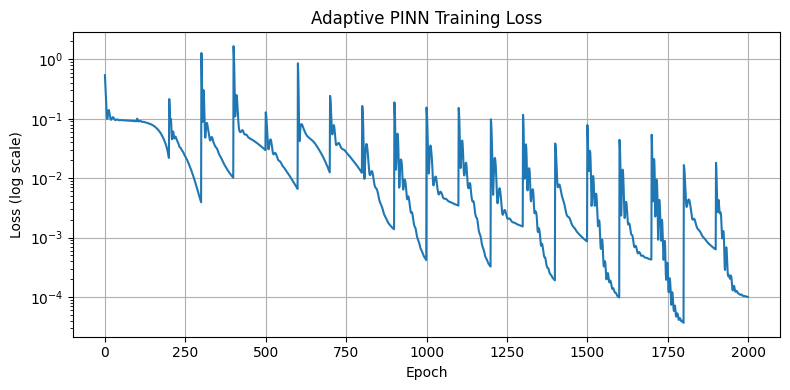

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the neural network
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(len(layers) - 2):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
            self.net.append(nn.Tanh())
        self.net.append(nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        return self.net(x)

# 2. PDE residual: Heat equation u_t = α u_xx
def pde_residual(model, x, t, alpha=0.1):
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(torch.cat([x, t], dim=1))

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]
    return u_t - alpha * u_xx

# 3. Initial condition
def initial_condition(x):
    return torch.sin(np.pi * x)

# 4. Residual-based adaptive collocation
def adaptive_collocation(model, Nf, alpha=0.1, device="cpu"):
    x = torch.rand(1000, 1, device=device, requires_grad=True)
    t = torch.rand(1000, 1, device=device, requires_grad=True)

    res = pde_residual(model, x, t, alpha).abs().squeeze()
    idx = torch.topk(res, k=Nf)[1]

    # Important: detach and re-enable gradients for training
    x_new = x[idx].detach().requires_grad_()
    t_new = t[idx].detach().requires_grad_()
    return x_new, t_new

# 5. Training loop
def train(model, epochs=2000, Nf=100, alpha=0.1, lr=1e-3, adapt_every=100, device="cpu"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initial condition data
    x_ic = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    t_ic = torch.zeros_like(x_ic).to(device)
    u_ic = initial_condition(x_ic).to(device)

    losses = []

    for epoch in range(epochs):
        model.train()

        # Update collocation points adaptively
        if epoch % adapt_every == 0 or epoch == 0:
            x_f, t_f = adaptive_collocation(model, Nf, alpha, device)

        optimizer.zero_grad()

        # Physics loss
        f = pde_residual(model, x_f, t_f, alpha)
        loss_f = torch.mean(f**2)

        # Initial condition loss
        u_pred = model(torch.cat([x_ic, t_ic], dim=1))
        loss_ic = torch.mean((u_pred - u_ic) ** 2)

        # Total loss
        loss = loss_f + loss_ic
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if epoch % 200 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.3e}")

    return losses

# 6. Run training
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PINN([2, 64, 64, 64, 1]).to(device)
losses = train(model, epochs=2000, Nf=100, device=device)

# 7. Plot loss
plt.figure(figsize=(8, 4))
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Adaptive PINN Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


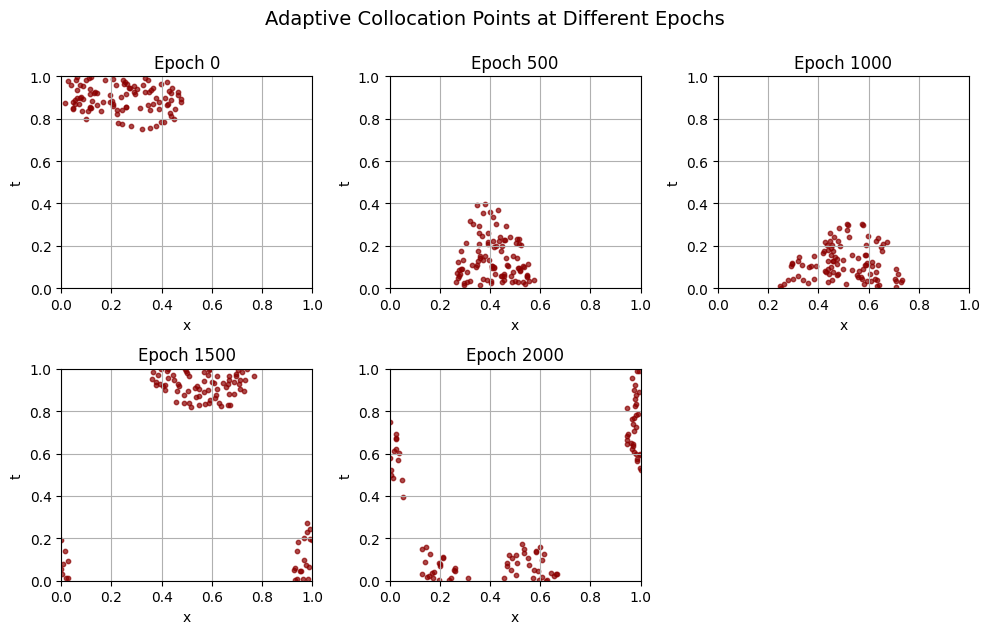

In [4]:
# Redefine everything needed from scratch to enable plotting of adaptive collocation mesh evolution

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(len(layers) - 2):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
            self.net.append(nn.Tanh())
        self.net.append(nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        return self.net(x)

# PDE residual for the 1D heat equation
def pde_residual(model, x, t, alpha=0.1):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(torch.cat([x, t], dim=1))
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    return u_t - alpha * u_xx

# Initial condition
def initial_condition(x):
    return torch.sin(np.pi * x)

# Adaptive collocation
def adaptive_collocation(model, Nf, alpha=0.1, device="cpu"):
    x = torch.rand(1000, 1, device=device, requires_grad=True)
    t = torch.rand(1000, 1, device=device, requires_grad=True)
    res = pde_residual(model, x, t, alpha).abs().squeeze()
    idx = torch.topk(res, k=Nf)[1]
    x_new = x[idx].detach().requires_grad_()
    t_new = t[idx].detach().requires_grad_()
    return x_new, t_new

# Training function with snapshot capture
def train_with_snapshots(model, epochs=2000, Nf=100, alpha=0.1, lr=1e-3, adapt_every=100, device="cpu", snapshot_epochs=[0, 500, 1000, 1500, 2000]):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    x_ic = torch.linspace(0, 1, 100).view(-1, 1).to(device)
    t_ic = torch.zeros_like(x_ic).to(device)
    u_ic = initial_condition(x_ic).to(device)
    mesh_snapshots = {}

    for epoch in range(epochs + 1):
        model.train()
        if epoch % adapt_every == 0 or epoch == 0:
            x_f, t_f = adaptive_collocation(model, Nf, alpha, device)
        if epoch in snapshot_epochs:
            mesh_snapshots[epoch] = (x_f.clone().detach().cpu(), t_f.clone().detach().cpu())

        optimizer.zero_grad()
        f = pde_residual(model, x_f, t_f, alpha)
        loss_f = torch.mean(f**2)
        u_pred = model(torch.cat([x_ic, t_ic], dim=1))
        loss_ic = torch.mean((u_pred - u_ic) ** 2)
        loss = loss_f + loss_ic
        loss.backward()
        optimizer.step()

    return mesh_snapshots

# Visualization function
def plot_adaptive_mesh_history(mesh_snapshots):
    plt.figure(figsize=(10, 6))
    for i, (epoch, (x_sel, t_sel)) in enumerate(mesh_snapshots.items()):
        plt.subplot(2, 3, i + 1)
        plt.scatter(x_sel, t_sel, s=10, c='darkred', alpha=0.7)
        plt.title(f"Epoch {epoch}")
        plt.xlabel("x")
        plt.ylabel("t")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True)
    plt.tight_layout()
    plt.suptitle("Adaptive Collocation Points at Different Epochs", y=1.05, fontsize=14)
    plt.show()

# Run training and visualization
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PINN([2, 64, 64, 64, 1]).to(device)
snapshots = train_with_snapshots(model, device=device)
plot_adaptive_mesh_history(snapshots)


Epoch 100, Loss = 1.2152e-05
Epoch 200, Loss = 7.2020e-07
Epoch 300, Loss = 4.1246e-07
Epoch 400, Loss = 2.5448e-07
Epoch 500, Loss = 1.6435e-07


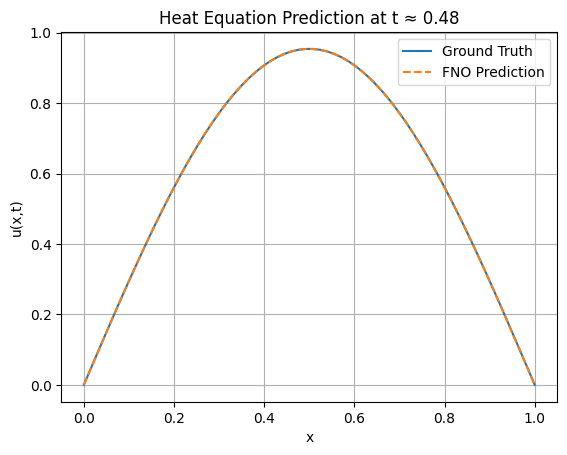

In [7]:
import torch
import torch.nn as nn
import torch.fft
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 1. Generate synthetic solution to 1D heat equation
def generate_heat_solution(alpha=0.01, Nx=64, Nt=64):
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0, 1, Nt)
    X, T = np.meshgrid(x, t)
    u = np.exp(-np.pi**2 * alpha * T) * np.sin(np.pi * X)
    return x, t, u

# 2. Dataset class
class HeatDataset(Dataset):
    def __init__(self, x, t, u):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.t = torch.tensor(t, dtype=torch.float32)
        self.u = torch.tensor(u, dtype=torch.float32)  # shape (Nt, Nx)

        self.input = torch.stack([
            torch.stack([self.x, t_i * torch.ones_like(self.x)], dim=-1)
            for t_i in self.t
        ])  # (Nt, Nx, 2)

        self.output = self.u  # (Nt, Nx)

    def __len__(self):
        return self.input.shape[0]

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

# 3. Spectral convolution 1D
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, dtype=torch.cfloat))

    def compl_mul1d(self, a, b):
        return torch.einsum("bix,iox->box", a, b)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x, dim=-1)
        out_ft = torch.zeros(batchsize, self.out_channels, x_ft.shape[-1], dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes] = self.compl_mul1d(x_ft[:, :, :self.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=x.size(-1), dim=-1)
        return x

# 4. FNO1D model
class FNO1d(nn.Module):
    def __init__(self, modes=16, width=64):
        super().__init__()
        self.fc0 = nn.Linear(2, width)
        self.conv1 = SpectralConv1d(width, width, modes)
        self.conv2 = SpectralConv1d(width, width, modes)
        self.w1 = nn.Conv1d(width, width, 1)
        self.w2 = nn.Conv1d(width, width, 1)
        self.fc1 = nn.Linear(width, width)
        self.fc2 = nn.Linear(width, 1)

    def forward(self, x):  # x: (B, L, 2)
        x = self.fc0(x)     # (B, L, width)
        x = x.permute(0, 2, 1)  # (B, width, L)
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = torch.relu(x)
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = x.permute(0, 2, 1)  # (B, L, width)
        x = torch.relu(self.fc1(x))
        return self.fc2(x).squeeze(-1)  # (B, L)

# 5. Training function
def train_fno(model, dataloader, epochs=500, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    model.train()
    for ep in range(epochs):
        epoch_loss = 0.0
        for xt, u in dataloader:  # xt: (B, L, 2), u: (B, L)
            pred = model(xt)
            loss = loss_fn(pred, u)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (ep + 1) % 100 == 0:
            print(f"Epoch {ep+1}, Loss = {epoch_loss / len(dataloader):.4e}")
    return model

# 6. Run everything
x, t, u = generate_heat_solution(alpha=0.01, Nx=64, Nt=64)
dataset = HeatDataset(x, t, u)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
model_fno = FNO1d(modes=16, width=64)
trained_fno = train_fno(model_fno, loader)

# 7. Plot prediction vs ground truth at a random time step
model_fno.eval()
with torch.no_grad():
    xt_sample, u_sample = dataset[30]
    u_pred = model_fno(xt_sample.unsqueeze(0)).squeeze(0)

plt.plot(x, u_sample.numpy(), label="Ground Truth")
plt.plot(x, u_pred.numpy(), label="FNO Prediction", linestyle="--")
plt.title("Heat Equation Prediction at t ≈ {:.2f}".format(t[30]))
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.grid(True)
plt.show()


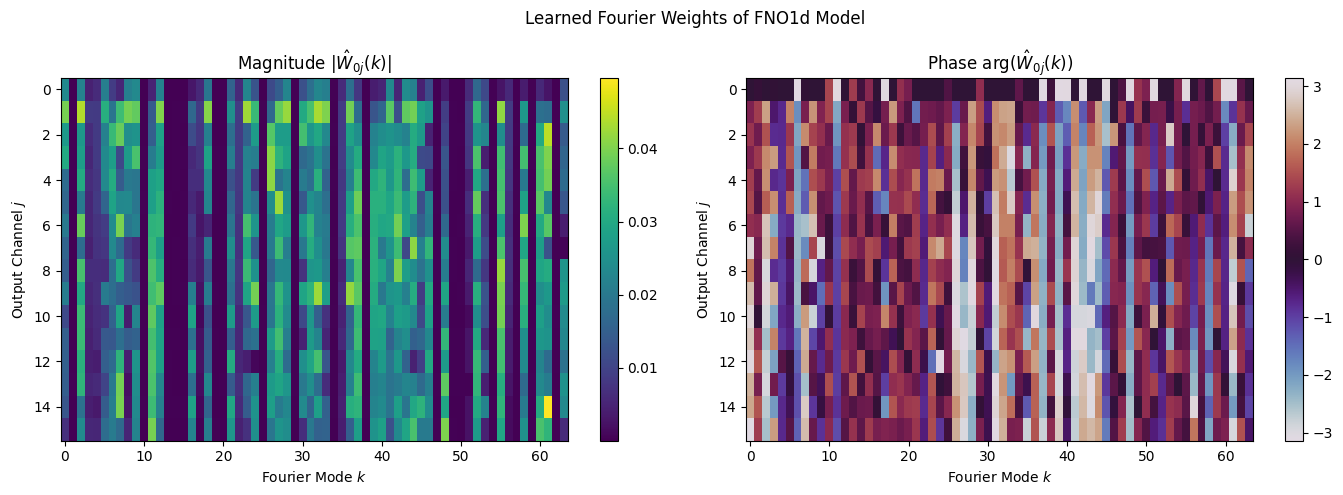

In [9]:
import matplotlib.pyplot as plt

def plot_fourier_weights(model, title="Learned Fourier Weights"):
    conv_layer = model.conv1  # or whichever SpectralConv1d you're using
    weights = conv_layer.weights.detach().cpu()  # shape: [in_channels, out_channels, modes]
    
    # We'll just visualize the magnitude of weights from input channel 0 to all output channels
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    magnitude = weights.abs()  # |W|
    phase = weights.angle()    # arg(W)

    # Show magnitude heatmap
    im1 = axes[0].imshow(magnitude[0].T, cmap='viridis', aspect='auto')
    axes[0].set_title("Magnitude $|\\hat{W}_{0j}(k)|$")
    axes[0].set_xlabel("Fourier Mode $k$")
    axes[0].set_ylabel("Output Channel $j$")
    fig.colorbar(im1, ax=axes[0])

    # Show phase heatmap
    im2 = axes[1].imshow(phase[0].T, cmap='twilight', aspect='auto')
    axes[1].set_title("Phase $\\arg(\\hat{W}_{0j}(k))$")
    axes[1].set_xlabel("Fourier Mode $k$")
    axes[1].set_ylabel("Output Channel $j$")
    fig.colorbar(im2, ax=axes[1])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_fourier_weights(trained_fno, title="Learned Fourier Weights of FNO1d Model")



## PyTorch Implementation

### Base PINN Class

```python
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, LBFGS
import torch.autograd as autograd

class PINN(nn.Module):
    def __init__(self, layers, activation=torch.tanh):
        super(PINN, self).__init__()
        self.activation = activation
        self.linears = nn.ModuleList()
        
        # Build network layers
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
            
        # Initialize weights using Xavier initialization
        self.init_weights()
    
    def init_weights(self):
        for m in self.linears:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        for i, layer in enumerate(self.linears[:-1]):
            x = self.activation(layer(x))
        x = self.linears[-1](x)  # No activation on output layer
        return x
    
    def loss_function(self, x_data, u_data, x_physics, x_boundary, u_boundary):
        """
        Compute the total loss function
        """
        # Data loss
        u_pred_data = self.forward(x_data)
        loss_data = torch.mean((u_pred_data - u_data)**2)
        
        # Physics loss (to be implemented in subclasses)
        loss_physics = self.physics_loss(x_physics)
        
        # Boundary loss
        u_pred_boundary = self.forward(x_boundary)
        loss_boundary = torch.mean((u_pred_boundary - u_boundary)**2)
        
        return loss_data + loss_physics + loss_boundary
    
    def physics_loss(self, x):
        """
        To be implemented in subclasses for specific PDEs
        """
        raise NotImplementedError
```

## Example 1: Simple ODE

Let's solve the simple ODE: `du/dt + u = 0` with initial condition `u(0) = 1`

The analytical solution is `u(t) = e^(-t)`.

```python
class ODE_PINN(PINN):
    def __init__(self, layers):
        super().__init__(layers)
    
    def physics_loss(self, t):
        """
        Compute physics loss for du/dt + u = 0
        """
        t.requires_grad_(True)
        u = self.forward(t)
        
        # Compute du/dt using automatic differentiation
        u_t = autograd.grad(u, t, 
                           grad_outputs=torch.ones_like(u),
                           create_graph=True)[0]
        
        # PDE residual: du/dt + u = 0
        pde_residual = u_t + u
        loss_physics = torch.mean(pde_residual**2)
        
        return loss_physics

def solve_ode_example():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Domain
    t_min, t_max = 0.0, 2.0
    
    # Training points
    n_physics = 100
    n_boundary = 1
    
    # Physics points (interior)
    t_physics = torch.linspace(t_min, t_max, n_physics).reshape(-1, 1)
    t_physics.requires_grad_(True)
    
    # Boundary point (initial condition)
    t_boundary = torch.tensor([[0.0]])
    u_boundary = torch.tensor([[1.0]])  # u(0) = 1
    
    # No data points for this example
    t_data = torch.empty(0, 1)
    u_data = torch.empty(0, 1)
    
    # Initialize network
    layers = [1, 50, 50, 50, 1]  # 1 input (t), 3 hidden layers, 1 output (u)
    model = ODE_PINN(layers)
    
    # Optimizer
    optimizer = Adam(model.parameters(), lr=0.001)
    
    # Training
    epochs = 5000
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Compute losses
        loss_data = torch.tensor(0.0)  # No data
        loss_physics = model.physics_loss(t_physics)
        
        u_pred_boundary = model.forward(t_boundary)
        loss_boundary = torch.mean((u_pred_boundary - u_boundary)**2)
        
        total_loss = loss_data + loss_physics + loss_boundary
        
        total_loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')
    
    # Test the solution
    with torch.no_grad():
        t_test = torch.linspace(0, 2, 100).reshape(-1, 1)
        u_pred = model.forward(t_test)
        u_exact = torch.exp(-t_test)
        
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(t_test.numpy(), u_exact.numpy(), 'r-', label='Exact solution', linewidth=2)
        plt.plot(t_test.numpy(), u_pred.numpy(), 'b--', label='PINN solution', linewidth=2)
        plt.xlabel('t')
        plt.ylabel('u(t)')
        plt.title('ODE Solution: du/dt + u = 0, u(0) = 1')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Compute error
        error = torch.mean((u_pred - u_exact)**2).item()
        print(f'Mean squared error: {error:.8f}')

# Run the example
solve_ode_example()
```

## Example 2: Heat Equation (PDE)

Now let's solve the 1D heat equation: `∂u/∂t = α ∂²u/∂x²`

With initial condition: `u(x, 0) = sin(πx)` and boundary conditions: `u(0, t) = u(1, t) = 0`

```python
class Heat_PINN(PINN):
    def __init__(self, layers, alpha=0.01):
        super().__init__(layers)
        self.alpha = alpha  # Thermal diffusivity
    
    def physics_loss(self, x_t):
        """
        Compute physics loss for heat equation
        """
        x_t.requires_grad_(True)
        u = self.forward(x_t)
        
        # First derivatives
        u_x_t = autograd.grad(u, x_t, 
                             grad_outputs=torch.ones_like(u),
                             create_graph=True)[0]
        u_x = u_x_t[:, 0:1]  # ∂u/∂x
        u_t = u_x_t[:, 1:2]  # ∂u/∂t
        
        # Second derivative ∂²u/∂x²
        u_xx = autograd.grad(u_x, x_t,
                            grad_outputs=torch.ones_like(u_x),
                            create_graph=True)[0][:, 0:1]
        
        # PDE residual: ∂u/∂t - α ∂²u/∂x² = 0
        pde_residual = u_t - self.alpha * u_xx
        loss_physics = torch.mean(pde_residual**2)
        
        return loss_physics

def solve_heat_equation():
    # Set random seed
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Domain
    x_min, x_max = 0.0, 1.0
    t_min, t_max = 0.0, 1.0
    alpha = 0.01
    
    # Training points
    n_physics = 10000
    n_boundary = 400
    n_initial = 100
    
    # Physics points (interior)
    x_physics = torch.rand(n_physics, 1) * (x_max - x_min) + x_min
    t_physics = torch.rand(n_physics, 1) * (t_max - t_min) + t_min
    x_t_physics = torch.cat([x_physics, t_physics], dim=1)
    
    # Boundary conditions: u(0,t) = u(1,t) = 0
    t_boundary = torch.rand(n_boundary//2, 1) * (t_max - t_min) + t_min
    x_boundary_left = torch.zeros_like(t_boundary)
    x_boundary_right = torch.ones_like(t_boundary)
    
    x_t_boundary = torch.cat([
        torch.cat([x_boundary_left, t_boundary], dim=1),
        torch.cat([x_boundary_right, t_boundary], dim=1)
    ], dim=0)
    u_boundary = torch.zeros(x_t_boundary.shape[0], 1)
    
    # Initial condition: u(x,0) = sin(πx)
    x_initial = torch.rand(n_initial, 1) * (x_max - x_min) + x_min
    t_initial = torch.zeros_like(x_initial)
    x_t_initial = torch.cat([x_initial, t_initial], dim=1)
    u_initial = torch.sin(np.pi * x_initial)
    
    # Combine boundary and initial conditions
    x_t_boundary_all = torch.cat([x_t_boundary, x_t_initial], dim=0)
    u_boundary_all = torch.cat([u_boundary, u_initial], dim=0)
    
    # Initialize network
    layers = [2, 100, 100, 100, 1]  # 2 inputs (x,t), 3 hidden layers, 1 output (u)
    model = Heat_PINN(layers, alpha=alpha)
    
    # Optimizer
    optimizer = Adam(model.parameters(), lr=0.001)
    
    # Training
    epochs = 10000
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Compute losses
        loss_physics = model.physics_loss(x_t_physics)
        
        u_pred_boundary = model.forward(x_t_boundary_all)
        loss_boundary = torch.mean((u_pred_boundary - u_boundary_all)**2)
        
        total_loss = loss_physics + loss_boundary
        
        total_loss.backward()
        optimizer.step()
        
        if epoch % 2000 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')
    
    # Test the solution
    with torch.no_grad():
        # Create test grid
        x_test = torch.linspace(0, 1, 100)
        t_test = torch.linspace(0, 1, 100)
        X_test, T_test = torch.meshgrid(x_test, t_test, indexing='ij')
        x_t_test = torch.cat([X_test.reshape(-1, 1), T_test.reshape(-1, 1)], dim=1)
        
        u_pred = model.forward(x_t_test)
        U_pred = u_pred.reshape(100, 100)
        
        # Analytical solution
        U_exact = torch.zeros_like(U_pred)
        for i in range(100):
            for j in range(100):
                x_val = X_test[i, j]
                t_val = T_test[i, j]
                U_exact[i, j] = torch.exp(-np.pi**2 * alpha * t_val) * torch.sin(np.pi * x_val)
        
        # Plot results
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        
        # PINN solution
        im1 = ax1.imshow(U_pred.T, extent=[0, 1, 0, 1], origin='lower', aspect='auto')
        ax1.set_title('PINN Solution')
        ax1.set_xlabel('x')
        ax1.set_ylabel('t')
        plt.colorbar(im1, ax=ax1)
        
        # Exact solution
        im2 = ax2.imshow(U_exact.T, extent=[0, 1, 0, 1], origin='lower', aspect='auto')
        ax2.set_title('Exact Solution')
        ax2.set_xlabel('x')
        ax2.set_ylabel('t')
        plt.colorbar(im2, ax=ax2)
        
        # Error
        error = torch.abs(U_pred - U_exact)
        im3 = ax3.imshow(error.T, extent=[0, 1, 0, 1], origin='lower', aspect='auto')
        ax3.set_title('Absolute Error')
        ax3.set_xlabel('x')
        ax3.set_ylabel('t')
        plt.colorbar(im3, ax=ax3)
        
        plt.tight_layout()
        plt.show()
        
        print(f'Mean absolute error: {torch.mean(error).item():.6f}')
        print(f'Max absolute error: {torch.max(error).item():.6f}')

# Run the example
solve_heat_equation()
```

## Example 3: Burgers' Equation

The viscous Burgers' equation is a fundamental PDE in fluid dynamics:
`∂u/∂t + u∂u/∂x = ν∂²u/∂x²`

```python
class Burgers_PINN(PINN):
    def __init__(self, layers, nu=0.01):
        super().__init__(layers)
        self.nu = nu  # Viscosity parameter
    
    def physics_loss(self, x_t):
        """
        Compute physics loss for Burgers' equation
        """
        x_t.requires_grad_(True)
        u = self.forward(x_t)
        
        # First derivatives
        u_x_t = autograd.grad(u, x_t,
                             grad_outputs=torch.ones_like(u),
                             create_graph=True)[0]
        u_x = u_x_t[:, 0:1]  # ∂u/∂x
        u_t = u_x_t[:, 1:2]  # ∂u/∂t
        
        # Second derivative ∂²u/∂x²
        u_xx = autograd.grad(u_x, x_t,
                            grad_outputs=torch.ones_like(u_x),
                            create_graph=True)[0][:, 0:1]
        
        # PDE residual: ∂u/∂t + u∂u/∂x - ν∂²u/∂x² = 0
        pde_residual = u_t + u * u_x - self.nu * u_xx
        loss_physics = torch.mean(pde_residual**2)
        
        return loss_physics

def solve_burgers_equation():
    # Set random seed
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Domain
    x_min, x_max = -1.0, 1.0
    t_min, t_max = 0.0, 1.0
    nu = 0.01/np.pi
    
    # Training points
    n_physics = 20000
    n_boundary = 100
    n_initial = 256
    
    # Physics points (interior)
    x_physics = torch.rand(n_physics, 1) * (x_max - x_min) + x_min
    t_physics = torch.rand(n_physics, 1) * (t_max - t_min) + t_min
    x_t_physics = torch.cat([x_physics, t_physics], dim=1)
    
    # Initial condition: u(x,0) = -sin(πx)
    x_initial = torch.linspace(x_min, x_max, n_initial).reshape(-1, 1)
    t_initial = torch.zeros_like(x_initial)
    x_t_initial = torch.cat([x_initial, t_initial], dim=1)
    u_initial = -torch.sin(np.pi * x_initial)
    
    # Boundary conditions (periodic)
    t_boundary = torch.rand(n_boundary, 1) * (t_max - t_min) + t_min
    x_boundary_left = torch.full_like(t_boundary, x_min)
    x_boundary_right = torch.full_like(t_boundary, x_max)
    
    x_t_boundary_left = torch.cat([x_boundary_left, t_boundary], dim=1)
    x_t_boundary_right = torch.cat([x_boundary_right, t_boundary], dim=1)
    
    # Initialize network
    layers = [2, 100, 100, 100, 100, 1]
    model = Burgers_PINN(layers, nu=nu)
    
    # Optimizer
    optimizer = Adam(model.parameters(), lr=0.001)
    
    # Training
    epochs = 15000
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Physics loss
        loss_physics = model.physics_loss(x_t_physics)
        
        # Initial condition loss
        u_pred_initial = model.forward(x_t_initial)
        loss_initial = torch.mean((u_pred_initial - u_initial)**2)
        
        # Periodic boundary condition loss
        u_pred_left = model.forward(x_t_boundary_left)
        u_pred_right = model.forward(x_t_boundary_right)
        loss_boundary = torch.mean((u_pred_left - u_pred_right)**2)
        
        total_loss = loss_physics + loss_initial + loss_boundary
        
        total_loss.backward()
        optimizer.step()
        
        if epoch % 3000 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')
    
    # Test the solution
    with torch.no_grad():
        # Create test grid
        n_test = 256
        x_test = torch.linspace(x_min, x_max, n_test)
        t_test = torch.linspace(t_min, t_max, 100)
        X_test, T_test = torch.meshgrid(x_test, t_test, indexing='ij')
        x_t_test = torch.cat([X_test.reshape(-1, 1), T_test.reshape(-1, 1)], dim=1)
        
        u_pred = model.forward(x_t_test)
        U_pred = u_pred.reshape(n_test, 100)
        
        # Plot results
        plt.figure(figsize=(12, 8))
        plt.imshow(U_pred.T, extent=[x_min, x_max, t_min, t_max], 
                  origin='lower', aspect='auto', cmap='viridis')
        plt.colorbar(label='u(x,t)')
        plt.xlabel('x')
        plt.ylabel('t')
        plt.title("Burgers' Equation Solution")
        plt.show()
        
        # Plot solution at different times
        plt.figure(figsize=(12, 6))
        times_to_plot = [0.0, 0.25, 0.5, 0.75, 1.0]
        colors = ['b', 'r', 'g', 'm', 'c']
        
        for i, t_val in enumerate(times_to_plot):
            t_idx = int(t_val * 99)  # Index for time
            plt.plot(x_test.numpy(), U_pred[:, t_idx].numpy(), 
                    color=colors[i], label=f't = {t_val}', linewidth=2)
        
        plt.xlabel('x')
        plt.ylabel('u(x,t)')
        plt.title("Burgers' Equation: Solution at Different Times")
        plt.legend()
        plt.grid(True)
        plt.show()

# Run the example
solve_burgers_equation()
```

## Advanced Techniques

### 1. Adaptive Weights

```python
class AdaptiveWeightPINN(PINN):
    def __init__(self, layers):
        super().__init__(layers)
        # Learnable loss weights
        self.lambda_data = nn.Parameter(torch.tensor(1.0))
        self.lambda_physics = nn.Parameter(torch.tensor(1.0))
        self.lambda_boundary = nn.Parameter(torch.tensor(1.0))
    
    def loss_function(self, x_data, u_data, x_physics, x_boundary, u_boundary):
        # Individual losses
        u_pred_data = self.forward(x_data)
        loss_data = torch.mean((u_pred_data - u_data)**2)
        
        loss_physics = self.physics_loss(x_physics)
        
        u_pred_boundary = self.forward(x_boundary)
        loss_boundary = torch.mean((u_pred_boundary - u_boundary)**2)
        
        # Weighted total loss
        total_loss = (self.lambda_data * loss_data + 
                     self.lambda_physics * loss_physics + 
                     self.lambda_boundary * loss_boundary)
        
        return total_loss, loss_data, loss_physics, loss_boundary
```

### 2. Residual-based Adaptive Refinement

```python
class AdaptiveRefinementPINN(PINN):
    def __init__(self, layers):
        super().__init__(layers)
        self.refinement_threshold = 0.1
        
    def adaptive_sampling(self, x_physics, max_points=50000):
        """
        Add more training points where PDE residual is high
        """
        with torch.no_grad():
            residuals = self.compute_residual(x_physics)
            high_residual_mask = residuals > self.refinement_threshold
            
            if high_residual_mask.sum() > 0:
                high_residual_points = x_physics[high_residual_mask.squeeze()]
                
                # Add noise around high-residual points
                n_new = min(1000, max_points - len(x_physics))
                if n_new > 0:
                    noise = 0.01 * torch.randn(n_new, x_physics.shape[1])
                    new_points = high_residual_points[:n_new] + noise
                    x_physics = torch.cat([x_physics, new_points], dim=0)
        
        return x_physics
```

### 3. Multi-scale Networks

```python
class MultiScalePINN(nn.Module):
    def __init__(self, layers_low, layers_high):
        super().__init__()
        self.net_low = PINN(layers_low)   # Low-frequency network
        self.net_high = PINN(layers_high) # High-frequency network
        
    def forward(self, x):
        return self.net_low(x) + self.net_high(x)
```

### 4. Fourier Feature Networks

```python
class FourierFeaturePINN(PINN):
    def __init__(self, layers, sigma=1.0):
        super().__init__(layers)
        self.sigma = sigma
        # Random Fourier features
        self.B = nn.Parameter(torch.randn(layers[0], layers[0]) * sigma, 
                             requires_grad=False)
    
    def fourier_features(self, x):
        x_proj = 2 * np.pi * torch.matmul(x, self.B)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)
    
    def forward(self, x):
        x = self.fourier_features(x)
        for i, layer in enumerate(self.linears[:-1]):
            x = self.activation(layer(x))
        x = self.linears[-1](x)
        return x
```

## Best Practices

### 1. Network Architecture
- **Hidden layers**: 3-8 layers typically work well
- **Neurons per layer**: 20-100, depending on problem complexity
- **Activation functions**: Tanh, Sine, or Swish often work better than ReLU
- **Output layer**: No activation for regression problems

### 2. Training Strategies
- **Optimizer**: Adam for initial training, L-BFGS for fine-tuning
- **Learning rate**: Start with 1e-3, decay if needed
- **Loss balancing**: Use adaptive weights or manual tuning
- **Training points**: More physics points than boundary points usually

### 3. Sampling Strategies
```python
# Latin Hypercube Sampling for better coverage
from scipy.stats import qmc

def latin_hypercube_sampling(bounds, n_samples):
    """
    Generate samples using Latin Hypercube Sampling
    """
    sampler = qmc.LatinHypercube(d=len(bounds))
    sample = sampler.random(n=n_samples)
    
    # Scale to bounds
    scaled_sample = qmc.scale(sample, 
                             [bound[0] for bound in bounds],
                             [bound[1] for bound in bounds])
    return torch.tensor(scaled_sample, dtype=torch.float32)
```

### 4. Initialization
```python
def init_weights_xavier(model):
    """
    Xavier/Glorot initialization
    """
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)
```

## Troubleshooting

### Common Issues and Solutions

#### 1. Training Instability
**Problem**: Loss oscillates or explodes
**Solutions**:
- Reduce learning rate
- Use gradient clipping
- Check loss term balancing
- Try different activation functions

```python
# Gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
```

#### 2. Poor Boundary Condition Satisfaction
**Problem**: Solution doesn't satisfy boundary conditions
**Solutions**:
- Increase boundary loss weight
- Add more boundary points
- Use hard constraints instead of soft constraints

```python
# Hard constraint example for Dirichlet BC
def apply_hard_constraint(self, x_t):
    x, t = x_t[:, 0:1], x_t[:, 1:2]
    u_net = self.forward(x_t)
    
    # For u(0,t) = 0, u(1,t) = 0
    u_constrained = x * (1 - x) * u_net
    return u_constrained
```

#### 3. Slow Convergence
**Problem**: Training takes too long
**Solutions**:
- Use L-BFGS optimizer for final refinement
- Implement learning rate scheduling
- Try different network architectures
- Use transfer learning from simpler problems

```python
# L-BFGS optimizer setup
def closure():
    optimizer.zero_grad()
    loss = model.loss_function(...)
    loss.backward()
    return loss

optimizer = torch.optim.LBFGS(model.parameters(), 
                             lr=1.0, 
                             max_iter=50000,
                             max_eval=50000,
                             tolerance_grad=1e-7,
                             tolerance_change=1.0*np.finfo(float).eps,
                             history_size=50,
                             line_search_fn="strong_wolfe")

optimizer.step(closure)
```

#### 4. High-Frequency Solutions
**Problem**: Network struggles with oscillatory solutions
**Solutions**:
- Use Fourier feature networks
- Increase network width
- Use sine activation functions
- Multi-scale network architectures

```python
# Sine activation for periodic problems
class SineActivation(nn.Module):
    def __init__(self, omega=1.0):
        super().__init__()
        self.omega = omega
    
    def forward(self, x):
        return torch.sin(self.omega * x)
```

#### 5. Vanishing Gradients
**Problem**: Gradients become very small during training
**Solutions**:
- Use residual connections
- Proper weight initialization
- Batch normalization (use carefully with PINNs)
- Different activation functions

```python
class ResidualPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
    
    def forward(self, x):
        residual = x
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.tanh(layer(x))
            if x.shape[-1] == residual.shape[-1]:
                x = x + residual  # Residual connection
            residual = x
        x = self.layers[-1](x)
        return x
```

## Advanced Applications

### 1. Inverse Problems

PINNs can discover unknown parameters in PDEs from data:

```python
class InversePINN(PINN):
    def __init__(self, layers):
        super().__init__(layers)
        # Unknown parameter to be learned
        self.lambda_param = nn.Parameter(torch.tensor(1.0))
    
    def physics_loss(self, x_t):
        """
        Example: Learning diffusion coefficient in heat equation
        """
        x_t.requires_grad_(True)
        u = self.forward(x_t)
        
        u_x_t = autograd.grad(u, x_t,
                             grad_outputs=torch.ones_like(u),
                             create_graph=True)[0]
        u_x = u_x_t[:, 0:1]
        u_t = u_x_t[:, 1:2]
        
        u_xx = autograd.grad(u_x, x_t,
                            grad_outputs=torch.ones_like(u_x),
                            create_graph=True)[0][:, 0:1]
        
        # PDE with unknown parameter
        pde_residual = u_t - self.lambda_param * u_xx
        return torch.mean(pde_residual**2)
```

### 2. Multi-Physics Problems

Coupling multiple physical phenomena:

```python
class CoupledPINN(PINN):
    def __init__(self, layers):
        super().__init__(layers)
        # Network outputs multiple variables [u, v, p]
        
    def physics_loss(self, x_t):
        """
        Example: Coupled heat and mass transfer
        """
        x_t.requires_grad_(True)
        outputs = self.forward(x_t)
        u, v = outputs[:, 0:1], outputs[:, 1:2]  # Temperature, concentration
        
        # Compute derivatives for both variables
        u_xt = autograd.grad(u, x_t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_xt = autograd.grad(v, x_t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        
        # Heat equation
        u_t, u_x = u_xt[:, 1:2], u_xt[:, 0:1]
        u_xx = autograd.grad(u_x, x_t, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
        pde1 = u_t - self.alpha * u_xx - self.coupling_coeff * v
        
        # Mass transfer equation
        v_t, v_x = v_xt[:, 1:2], v_xt[:, 0:1]
        v_xx = autograd.grad(v_x, x_t, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0:1]
        pde2 = v_t - self.beta * v_xx + self.reaction_rate * u * v
        
        return torch.mean(pde1**2) + torch.mean(pde2**2)
```

### 3. Stochastic PINNs

For problems with uncertainty:

```python
class StochasticPINN(PINN):
    def __init__(self, layers):
        super().__init__(layers)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, training=True):
        if training:
            for i, layer in enumerate(self.linears[:-1]):
                x = self.dropout(self.activation(layer(x)))
        else:
            for i, layer in enumerate(self.linears[:-1]):
                x = self.activation(layer(x))
        x = self.linears[-1](x)
        return x
    
    def predict_with_uncertainty(self, x, n_samples=100):
        """
        Monte Carlo estimation of uncertainty
        """
        self.train()
        predictions = []
        for _ in range(n_samples):
            with torch.no_grad():
                pred = self.forward(x, training=True)
                predictions.append(pred)
        
        predictions = torch.stack(predictions)
        mean = torch.mean(predictions, dim=0)
        std = torch.std(predictions, dim=0)
        
        return mean, std
```

## Performance Optimization

### 1. GPU Acceleration

```python
def setup_device():
    """
    Setup GPU if available
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    return device

# Move model and data to GPU
device = setup_device()
model = model.to(device)
x_physics = x_physics.to(device)
x_boundary = x_boundary.to(device)
```

### 2. Memory Optimization

```python
def train_with_batching(model, optimizer, x_physics, batch_size=1000):
    """
    Training with mini-batches to save memory
    """
    n_batches = len(x_physics) // batch_size
    
    for epoch in range(epochs):
        total_loss = 0
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(x_physics))
            
            x_batch = x_physics[start_idx:end_idx]
            
            optimizer.zero_grad()
            loss = model.physics_loss(x_batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Average Loss: {total_loss/n_batches:.6f}')
```

### 3. Checkpointing

```python
def save_checkpoint(model, optimizer, epoch, loss, filename):
    """
    Save training checkpoint
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)

def load_checkpoint(model, optimizer, filename):
    """
    Load training checkpoint
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss
```

## Validation and Testing

### 1. Cross-Validation

```python
def k_fold_validation(data, k=5):
    """
    K-fold cross-validation for PINNs
    """
    fold_size = len(data) // k
    errors = []
    
    for i in range(k):
        # Split data
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size
        
        test_data = data[start_idx:end_idx]
        train_data = torch.cat([data[:start_idx], data[end_idx:]], dim=0)
        
        # Train model on training data
        model = PINN([2, 50, 50, 1])
        # ... training code ...
        
        # Test on validation data
        with torch.no_grad():
            pred = model(test_data)
            # Calculate error
            error = calculate_error(pred, true_values)
            errors.append(error)
    
    return np.mean(errors), np.std(errors)
```

### 2. Convergence Analysis

```python
def convergence_study():
    """
    Study convergence with respect to number of training points
    """
    n_points_list = [100, 500, 1000, 5000, 10000]
    errors = []
    
    for n_points in n_points_list:
        # Generate training points
        x_physics = generate_physics_points(n_points)
        
        # Train model
        model = PINN([2, 50, 50, 1])
        train_model(model, x_physics)
        
        # Compute error on test set
        error = compute_test_error(model)
        errors.append(error)
    
    # Plot convergence
    plt.loglog(n_points_list, errors, 'o-')
    plt.xlabel('Number of training points')
    plt.ylabel('Test error')
    plt.title('Convergence Study')
    plt.grid(True)
    plt.show()
```

## Integration with Scientific Computing

### 1. Comparison with Traditional Methods

```python
def compare_with_fem(pinn_model, domain, exact_solution):
    """
    Compare PINN solution with Finite Element Method
    """
    # Generate test points
    x_test = torch.linspace(domain[0], domain[1], 1000).reshape(-1, 1)
    
    # PINN prediction
    with torch.no_grad():
        u_pinn = pinn_model(x_test)
    
    # FEM solution (using external library like FEniCS)
    # u_fem = solve_with_fem(domain)
    
    # Exact solution
    u_exact = exact_solution(x_test)
    
    # Compute errors
    error_pinn = torch.mean((u_pinn - u_exact)**2).item()
    # error_fem = compute_fem_error(u_fem, u_exact)
    
    print(f'PINN L2 error: {error_pinn:.6f}')
    # print(f'FEM L2 error: {error_fem:.6f}')
    
    return error_pinn
```

### 2. Mesh-Free Advantage

```python
def demonstrate_mesh_free():
    """
    Show advantage of mesh-free approach
    """
    # Complex domain (e.g., L-shaped domain)
    def is_in_domain(x, y):
        return ((x >= 0) & (x <= 1) & (y >= 0) & (y <= 1)) | \
               ((x >= 0) & (x <= 0.5) & (y >= 1) & (y <= 1.5))
    
    # Generate random points in complex domain
    n_points = 10000
    x_rand = torch.rand(n_points, 1) * 1.5
    y_rand = torch.rand(n_points, 1) * 1.5
    
    mask = is_in_domain(x_rand, y_rand)
    x_domain = x_rand[mask.squeeze()]
    y_domain = y_rand[mask.squeeze()]
    
    # PINN can handle this directly without mesh generation
    xy_physics = torch.cat([x_domain, y_domain], dim=1)
    
    return xy_physics
```

## Future Directions and Extensions

### 1. Neural Operators
PINNs can be extended to learn operators:

```python
class DeepONet(nn.Module):
    """
    Deep Operator Network for learning operators
    """
    def __init__(self, branch_layers, trunk_layers):
        super().__init__()
        self.branch_net = PINN(branch_layers)  # For input functions
        self.trunk_net = PINN(trunk_layers)    # For coordinates
    
    def forward(self, u_sensors, y_coords):
        # Branch network processes input function
        branch_output = self.branch_net(u_sensors)
        
        # Trunk network processes coordinates
        trunk_output = self.trunk_net(y_coords)
        
        # Combine via dot product
        output = torch.sum(branch_output * trunk_output, dim=1, keepdim=True)
        return output
```

### 2. Automated Discovery
PINNs for discovering governing equations:

```python
class EquationDiscoveryPINN(PINN):
    def __init__(self, layers, library_functions):
        super().__init__(layers)
        self.library = library_functions
        self.coefficients = nn.Parameter(torch.randn(len(library_functions)))
    
    def compute_library_terms(self, u, u_x, u_t, u_xx):
        """
        Compute library of candidate terms
        """
        terms = []
        terms.append(u)      # u
        terms.append(u_x)    # ∂u/∂x
        terms.append(u_t)    # ∂u/∂t
        terms.append(u * u_x) # u∂u/∂x
        terms.append(u_xx)   # ∂²u/∂x²
        # Add more terms as needed
        
        return torch.cat(terms, dim=1)
    
    def discovered_equation(self, x_t):
        """
        Return discovered PDE based on learned coefficients
        """
        # Compute derivatives
        # ...
        
        # Compute library terms
        library_terms = self.compute_library_terms(u, u_x, u_t, u_xx)
        
        # Sparse regression to find active terms
        pde_residual = torch.sum(self.coefficients * library_terms, dim=1, keepdim=True)
        
        return pde_residual
```

## Complete Example: Navier-Stokes Equations

Here's a comprehensive example solving the 2D Navier-Stokes equations:

```python
class NavierStokesPINN(PINN):
    def __init__(self, layers, Re=100):
        super().__init__(layers)
        self.Re = Re  # Reynolds number
    
    def forward(self, x_t):
        """
        Network outputs: [u, v, p] (velocity components and pressure)
        """
        output = super().forward(x_t)
        return output[:, 0:1], output[:, 1:2], output[:, 2:3]
    
    def physics_loss(self, x_t):
        x_t.requires_grad_(True)
        u, v, p = self.forward(x_t)
        
        # Compute derivatives
        u_xt = autograd.grad(u, x_t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_xt = autograd.grad(v, x_t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        p_xt = autograd.grad(p, x_t, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        
        u_x, u_y, u_t = u_xt[:, 0:1], u_xt[:, 1:2], u_xt[:, 2:3]
        v_x, v_y, v_t = v_xt[:, 0:1], v_xt[:, 1:2], v_xt[:, 2:3]
        p_x, p_y = p_xt[:, 0:1], p_xt[:, 1:2]
        
        # Second derivatives
        u_xx = autograd.grad(u_x, x_t, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
        u_yy = autograd.grad(u_y, x_t, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
        v_xx = autograd.grad(v_x, x_t, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0:1]
        v_yy = autograd.grad(v_y, x_t, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1:2]
        
        # Navier-Stokes equations
        # Continuity equation: ∇·u = 0
        continuity = u_x + v_y
        
        # Momentum equations
        momentum_u = u_t + u * u_x + v * u_y + p_x - (1/self.Re) * (u_xx + u_yy)
        momentum_v = v_t + u * v_x + v * v_y + p_y - (1/self.Re) * (v_xx + v_yy)
        
        # Total physics loss
        loss_continuity = torch.mean(continuity**2)
        loss_momentum_u = torch.mean(momentum_u**2)
        loss_momentum_v = torch.mean(momentum_v**2)
        
        return loss_continuity + loss_momentum_u + loss_momentum_v

def solve_cavity_flow():
    """
    Solve lid-driven cavity flow problem
    """
    # Domain: [0,1] x [0,1] x [0,T]
    Re = 100
    
    # Training points
    n_physics = 20000
    n_boundary = 2000
    
    # Physics points (interior)
    x_physics = torch.rand(n_physics, 1)
    y_physics = torch.rand(n_physics, 1)
    t_physics = torch.rand(n_physics, 1) * 1.0  # T = 1.0
    xyt_physics = torch.cat([x_physics, y_physics, t_physics], dim=1)
    
    # Boundary conditions
    # Bottom, left, right walls: u = v = 0
    # Top wall: u = 1, v = 0 (lid velocity)
    
    # ... (boundary condition setup)
    
    # Initialize network
    layers = [3, 100, 100, 100, 100, 3]  # 3 inputs (x,y,t), 3 outputs (u,v,p)
    model = NavierStokesPINN(layers, Re=Re)
    
    # Training
    optimizer = Adam(model.parameters(), lr=0.001)
    
    epochs = 50000
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        loss_physics = model.physics_loss(xyt_physics)
        # Add boundary losses...
        
        total_loss = loss_physics  # + boundary losses
        total_loss.backward()
        optimizer.step()
        
        if epoch % 5000 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')
    
    return model

# Run Navier-Stokes example
# ns_model = solve_cavity_flow()
```

## Conclusion

Physics-Informed Neural Networks represent a powerful paradigm shift in scientific computing, bridging machine learning and traditional numerical methods. This guide has covered:

- **Theoretical foundations** of PINNs and their mathematical formulation
- **Practical implementations** in PyTorch with complete working examples
- **Advanced techniques** for improving performance and handling complex problems
- **Best practices** for training and validation
- **Troubleshooting** common issues and their solutions
- **Future directions** and extensions

Key takeaways:
1. PINNs excel at incorporating physical constraints directly into the learning process
2. They can solve both forward and inverse problems with limited data
3. Proper loss balancing and network architecture are crucial for success
4. Advanced techniques like adaptive refinement and multi-scale networks can significantly improve performance

The field of PINNs is rapidly evolving, with new architectures, training strategies, and applications being developed continuously. This guide provides a solid foundation for getting started with PINNs and exploring their potential in your specific domain.

### References and Further Reading

- Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks
- Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (2021). DeepXDE: A deep learning library
- Wang, S., Teng, Y., & Perdikaris, P. (2021). Understanding and mitigating gradient flow pathologies
- Cai, S., et al. (2021). Physics-informed neural networks for heat transfer problems
- Jin, X., et al. (2021). NSFnets: Navier-Stokes flow nets

For the latest developments and research papers, check:
- [DeepXDE Documentation](https://deepxde.readthedocs.io/)
- [PINN Papers Repository](https://github.com/maziarraissi/PINNs)
- [SciML Organization](https://sciml.ai/)

Happy coding with PINNs! 🚀